### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import time
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
# import tsfresh as tsf
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import mean_squared_error #roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
# Tensorflow
import tensorflow as tf

from stable_baselines import PPO2, DQN, A2C
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.env_checker import check_env
from stable_baselines.common import make_vec_env

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
init_notebook_mode(connected=True)

##### Local

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Metrics, _Metrics, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest, SingleAssetEnv

### Initialization

In [9]:
cred = Cred()

In [10]:
portfolio = ['ADA', 'NEO', 'TRX', 'BAT', 'XLM', 'IOTA', 'XRP', 'XTZ', 'DASH', 'EOS']
top = ['BTC', 'ETH', 'LINK', 'LTC', 'BCH', 'XMR', 'YFI']
bases = set(portfolio + top)

In [11]:
quotes_or_assets = [_+'USDT' for _ in bases]

In [12]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_metrics = [(_, (__,)) for _ in [_+'MA' for _ in ['S', 'E', 'W', 'H']] for __ in (200, 100, 50)]
store_metrics += [('EMA', (26,)), ('EMA', (12,))]
store_signals = None

In [13]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path)

### Update

In [13]:
print(datetime.utcnow().replace(microsecond=0))

2021-01-16 10:03:18


In [14]:
klmngr.info.reindex(quotes_or_assets).last_update.max()

'2021-01-09 08:00:00'

In [15]:
klmngr.update(verbose=1)

100%|██████████| 17/17 [01:54<00:00,  6.75s/it]


In [16]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

Timestamp('2021-01-16 10:00:00')

### Exploration

Future values scaler correction

In [15]:
from scipy import interpolate
from scipy.stats import genextreme

In [16]:
def get_extreme_perc(data, perc=(0.05, 0.95)):
    params = genextreme.fit(data)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    perc = np.array([genextreme.ppf(_, c=0, loc=loc, scale=scale) for _ in perc])
    return perc

def get_extreme_multiplier(data, train_perc=.4, perc=(0.05, 0.95), return_perc=False):
    data_train = data[:int(data.shape[0]*train_perc)]
    train_perc = get_extreme_perc(data=data_train, perc=perc)
    valid_perc = get_extreme_perc(data=data, perc=perc)
    if return_perc:
        return np.vstack([train_perc, valid_perc])
    return valid_perc/train_perc

def get_corrected_extremes(data, train_perc=.4, perc=(0.05, 0.95)):
    true_min, true_max = [func(data) for func in [min, max]]
    min_multiplier, max_multiplier = get_extreme_multiplier(data=data, train_perc=train_perc, perc=perc)
    corrected_min = np.min([true_min, true_min*min_multiplier])
    corrected_max = np.max([true_max, true_max*max_multiplier])
    return np.array([corrected_min, corrected_max])

In [17]:
def get_minmax_perc(data, perc=(0.05, 0.95)):
    params = genextreme.fit(data)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    perc = np.array([np.quantile(data, _) for _ in perc])
    return perc

def get_minmax_multiplier(data, train_perc=.4, perc=(0.05, 0.95), return_perc=False):
    data_train = data[:int(data.shape[0]*train_perc)]
    train_perc = get_minmax_perc(data=data_train, perc=perc)
    valid_perc = get_minmax_perc(data=data, perc=perc)
    if return_perc:
        return np.vstack([train_perc, valid_perc])
    return valid_perc/train_perc

def get_corrected_minmax(data, train_perc=.4, perc=(0.05, 0.95)):
    true_min, true_max = [func(data) for func in [min, max]]
    min_multiplier, max_multiplier = get_minmax_multiplier(data=data, train_perc=train_perc, perc=perc)
    corrected_min = np.min([true_min, true_min*min_multiplier])
    corrected_max = np.max([true_max, true_max*max_multiplier])
    return np.array([corrected_min, corrected_max])

In [18]:
def forecast_params(data, ticks=[.7, .8, .9, 1], interpolator=interpolate.InterpolatedUnivariateSpline, **kwargs):
    all_params = [genextreme.fit(data[:int(_*data.size)]) for _ in ticks]
    args = [params[:-2] for params in all_params]
    locs = [params[-2] for params in all_params]
    scales = [params[-1] for params in all_params]
    arg, loc, scale = [interpolator(range(len(_)), _, **kwargs)(len(_)+1) for _ in (args, locs, scales)]
    arg = args[-1]
    scale = scales[-1]
    return arg, loc, scale

def get_rvs_data(data, validation_window, ticks=[.7, .8, .9, 1], interpolator=interpolate.InterpolatedUnivariateSpline, **kwargs):
    arg, loc, scale = forecast_params(data=data, ticks=ticks, interpolator=interpolator, **kwargs)
    scale = max(0, scale)
    rvs_data = genextreme.rvs(c=arg, loc=loc, scale=scale, size=validation_window)
    return rvs_data

In [19]:
asset_nr = 1
asset = klmngr.assets[asset_nr]
data = klmngr[asset].close.values
scaler_to_test = StandardScaler() # MinMaxScaler((-1, 1))

print(asset)

BATUSDT


In [31]:
# def corrector(data, validation_window):
#     forecasted_min, forecasted_max = get_corrected_extremes(data)
#     rescaled_data = MinMaxScaler((forecasted_min, forecasted_max)).fit_transform(data[-validation_window:])
#     length = int(rescaled_data.shape[0])
#     factor = 1
#     return np.vstack([data[-length*factor:], rescaled_data]) # rescaled_data

# def corrector(data, validation_window):
#     forecasted_min, forecasted_max = get_corrected_minmax(data)
#     rescaled_data = MinMaxScaler((forecasted_min, forecasted_max)).fit_transform(data[-validation_window:])
#     length = int(rescaled_data.shape[0])
#     factor = 1
#     return np.vstack([data[-length*factor:], rescaled_data]) # rescaled_data

def corrector(data, validation_window):
    rvs_data = get_rvs_data(data, validation_window*2).reshape(-1, 1)
    length = int(rvs_data.shape[0])
    factor = 0
    return np.vstack([data[-length*factor:], rvs_data]) # rvs_data

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats

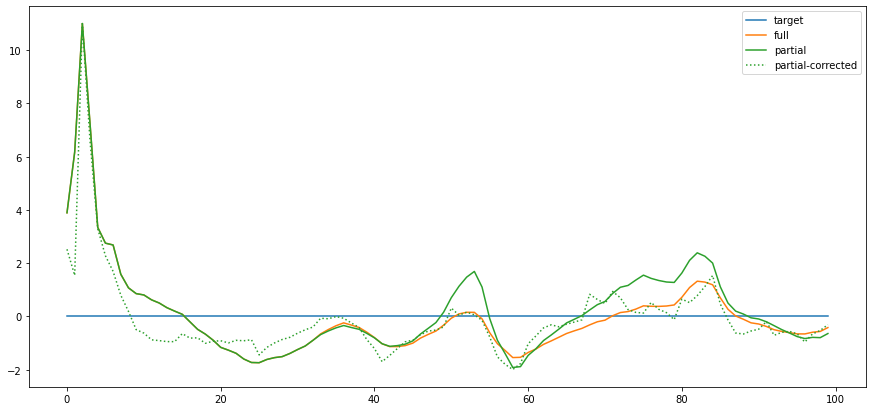

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats

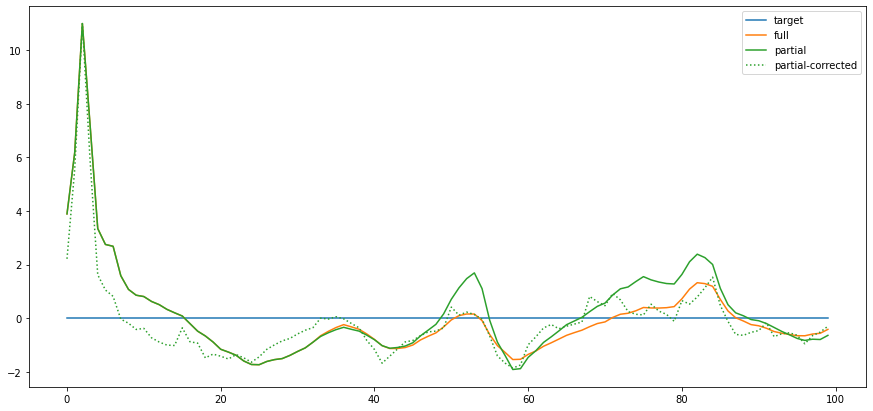

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats

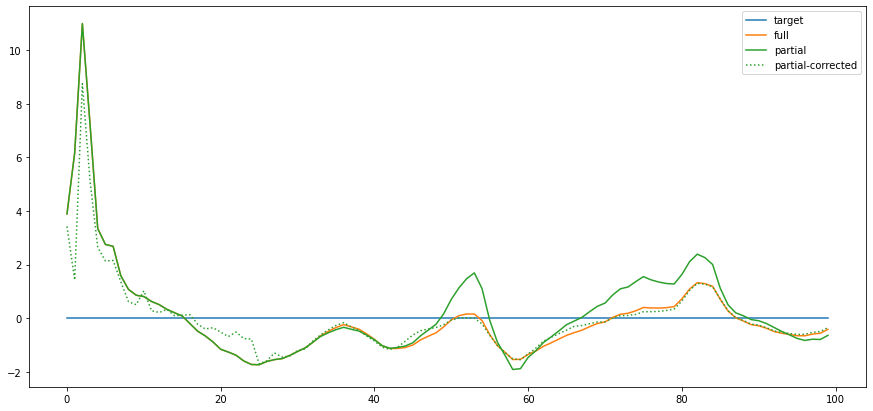

In [ ]:
steps = 100
window = int(data.size/steps)
validation_window = 24*30
historical_window = 5000

means0 , means1 , means2, means3 = [], [], [], []
medians0 , medians1 , medians2, medians3 = [], [], [], []
mins0 , mins1 , mins2, mins3 = [], [], [], []
maxs0 , maxs1 , maxs2, maxs3 = [], [], [], []

for i in range(steps):
    
    scaler = scaler.fit(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means0.append(np.mean(data_scaled))
    medians0.append(np.median(data_scaled))
    mins0.append(np.min(data_scaled))
    maxs0.append(np.max(data_scaled))

    scaler = scaler.fit(data[:(i+1)*window].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means1.append(np.mean(data_scaled))
    medians1.append(np.median(data_scaled))
    mins1.append(np.min(data_scaled))
    maxs1.append(np.max(data_scaled))

    scaler = scaler.fit(data[:(i+1)*window][-historical_window:].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means2.append(np.mean(data_scaled))
    medians2.append(np.median(data_scaled))
    mins2.append(np.min(data_scaled))
    maxs2.append(np.max(data_scaled))
 
    corrected_data = corrector(data[:(i+1)*window].reshape(-1, 1), validation_window)
    scaler = scaler.fit(corrected_data)
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means3.append(np.mean(data_scaled))
    medians3.append(np.median(data_scaled))
    mins3.append(np.min(data_scaled))
    maxs3.append(np.max(data_scaled))

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(means0, label='target', color='C0')
plt.plot(means1, label='full', color='C1')
plt.plot(means2, label='partial', color='C2')
plt.plot(means3, label='partial-corrected', color='C2', linestyle=':')
plt.legend()
#plt.plot(medians)
#plt.plot(mins)
#plt.plot(maxs)

##### Gaps

In [14]:
_ = 'BTCUSDT' #klmngr.assets[4]

In [15]:
set(pd.date_range(klmngr[_].start, klmngr[_].end, freq='H')) - set(klmngr[_].index)

{Timestamp('2017-09-06 16:00:00', freq='H'),
 Timestamp('2017-09-06 17:00:00', freq='H'),
 Timestamp('2017-09-06 18:00:00', freq='H'),
 Timestamp('2017-09-06 19:00:00', freq='H'),
 Timestamp('2017-09-06 20:00:00', freq='H'),
 Timestamp('2017-09-06 21:00:00', freq='H'),
 Timestamp('2017-09-06 22:00:00', freq='H'),
 Timestamp('2018-01-04 04:00:00', freq='H'),
 Timestamp('2018-02-08 01:00:00', freq='H'),
 Timestamp('2018-02-08 02:00:00', freq='H'),
 Timestamp('2018-02-08 03:00:00', freq='H'),
 Timestamp('2018-02-08 04:00:00', freq='H'),
 Timestamp('2018-02-08 05:00:00', freq='H'),
 Timestamp('2018-02-08 06:00:00', freq='H'),
 Timestamp('2018-02-08 07:00:00', freq='H'),
 Timestamp('2018-02-08 08:00:00', freq='H'),
 Timestamp('2018-02-08 09:00:00', freq='H'),
 Timestamp('2018-02-08 10:00:00', freq='H'),
 Timestamp('2018-02-08 11:00:00', freq='H'),
 Timestamp('2018-02-08 12:00:00', freq='H'),
 Timestamp('2018-02-08 13:00:00', freq='H'),
 Timestamp('2018-02-08 14:00:00', freq='H'),
 Timestamp

##### Total size

In [16]:
np.sum([_.shape[0] for _ in klmngr.listedvalues()])

313947

In [26]:
[(_.name, _.shape[0]) for _ in klmngr.listedvalues()]

[('BTCUSDT', 28030),
 ('ETHUSDT', 28030),
 ('NEOUSDT', 25758),
 ('LTCUSDT', 25206),
 ('ADAUSDT', 22238),
 ('XRPUSDT', 21826),
 ('EOSUSDT', 21253),
 ('IOTAUSDT', 21177),
 ('XLMUSDT', 21177),
 ('TRXUSDT', 20911),
 ('LINKUSDT', 15684),
 ('BATUSDT', 14556),
 ('XMRUSDT', 14304),
 ('DASHUSDT', 13992),
 ('XTZUSDT', 9683),
 ('BCHUSDT', 8128),
 ('YFIUSDT', 1994)]

##### Visualize asset candlestick

In [ ]:
asset='BTCUSDT'

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=klmngr[asset].index
                        ,y=(klmngr[asset].close-klmngr[asset].open)))
#fig.add_trace(go.Scatter(x=klmngr[asset].index
#                        ,y=(klmngr[asset].close)*(klmngr['BTCUSDT'].loc[klmngr[asset].index,'close'])))
klmngr[asset].plot(days=365*5, fig=fig)

### Baseline

In [14]:
from cryptoast.model.agents import SingleAssetEnv

In [179]:
kline = klmngr['BTCUSDT'] # klmngr['XRPUSDT']

In [180]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.iloc[:, :4].mean(axis=1).shift(1).values[:-1]
_sigs = pd.Series(_sigs).rolling(24).mean().fillna(1)
sigs = np.where(_sigs>=.8, 1, np.where(_sigs<0.4, -1, 0)) # sigs = np.where(sigs>=0.15, 1, np.where(sigs<=-0.05, -1, 0))

In [181]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=1)
btst.run(999*sigs, verbose=0)

In [ ]:
linspace = np.linspace(0, 1, 11)
combos = pd.MultiIndex.from_product([linspace, linspace])
perfs = []
for combo in combos:
    sigs = np.where(_sigs>=combo[0], 1, np.where(_sigs<combo[1], -1, 0))
    btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=1)
    btst.run(999*sigs, verbose=0)
    perfs.append(np.mean(btst.periodic.value.values-kline.close.values))
[combos[perfs.loc[perfs==np.sort(perfs.unique())[::-1][i]].index[0]] for i in range(10)]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btst.periodic.index, y=btst.periodic.value))
kline.plot(days=99999, fig=fig)

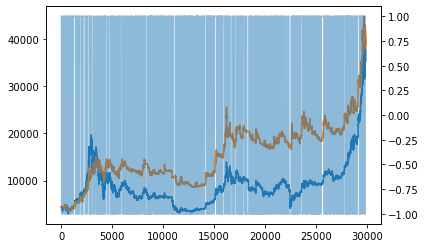

In [97]:
# 0.4, 0.5
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

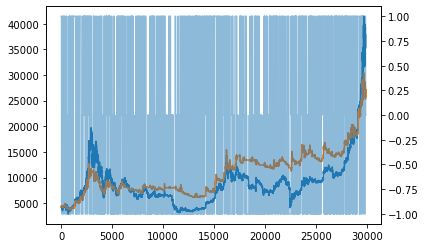

In [156]:
# 0.6, 0.4
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

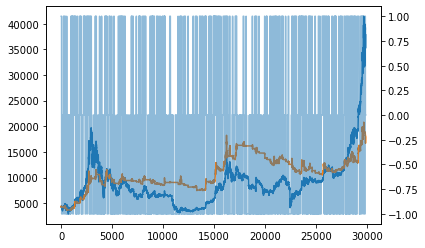

In [152]:
# 0.8, 0.4 # Most stable accross bullish / bearish
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Model test 2: RF

##### Discrete action, Single Process

In [22]:
train_assets = list(set(klmngr.assets)-set(['BTCUSDT']))

Testing ground

In [23]:
from cryptoast.model.agents import SingleAssetEnv

In [45]:
asset = np.random.choice(klmngr.assets) # 'BTCUSDT'
btst = Backtest(kline=klmngr[asset])
env = SingleAssetEnv(klmngr, assets=train_assets, backtest=btst, window=24, )

59


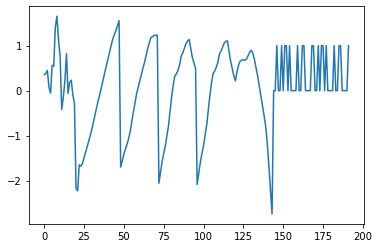

In [120]:
obs = env.step(np.random.choice([0, 1, 2]))[0]
print(env.current_step)
plt.plot(obs)

In [523]:
check_env(env, warn=True)

0.003931408851634641


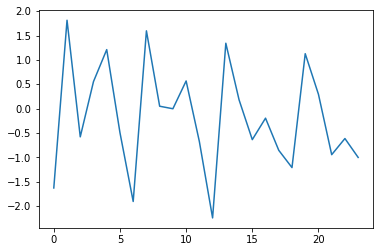

In [260]:
obs, reward, _, __ = env.step(2)
plt.plot(obs[:24])
print(reward)

DQN

In [31]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP
from stable_baselines.common.callbacks import EvalCallback

In [32]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [50]:
window = 24*7
# btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0.01, slippage_steps=0, memory=window)
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0, slippage_steps=0, memory=window)
env_kwargs = dict(klmngr=klmngr,
                  assets=list(set(klmngr.assets)-set(['BTCUSDT'])),
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=24*120)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [51]:
eval_callback = EvalCallback(env, best_model_save_path='./models/h5/',
                             log_path='./models/logs/', eval_freq=500,
                             deterministic=True, render=False)

In [52]:
total_timesteps = 500*1000
model = DQN(policy='MlpPolicy', env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=4, prioritized_replay=True, verbose=1)
#model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=4, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=4, prioritized_replay=True, tensorboard_log='C:/Users/guill/Documents/Code/crypto-invest/models/logs', verbose=1).learn(total_timesteps)
# model = PPO(policy='MlpPolicy', env=env, verbose=1).learn(total_timesteps)
# model = A2C(policy='MlpPolicy', env=env, verbose=1).learn(total_timesteps)

model.learn(total_timesteps, callback=eval_callback) # callback=eval_callback

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\stable_baselines\common\callbacks.py:287: UserWarning:

Training and eval env are not of the same type<stable_baselines.common.base_class._UnvecWrapper object at 0x000002180C5AF708> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x00000217F6B47E48>



Eval num_timesteps=500, episode_reward=-44.30 +/- 48.13
Episode length: 879.20 +/- 812.23
New best mean reward!
Eval num_timesteps=1000, episode_reward=-58.41 +/- 20.65
Episode length: 1074.60 +/- 466.12
Eval num_timesteps=1500, episode_reward=-6.30 +/- 12.46
Episode length: 430.40 +/- 455.88
New best mean reward!
Eval num_timesteps=2000, episode_reward=-59.33 +/- 71.81
Episode length: 701.00 +/- 307.15
Eval num_timesteps=2500, episode_reward=-150.39 +/- 99.58
Episode length: 1383.80 +/- 650.87
Eval num_timesteps=3000, episode_reward=-97.98 +/- 95.39
Episode length: 729.40 +/- 695.51
Eval num_timesteps=3500, episode_reward=-32.41 +/- 47.34
Episode length: 599.60 +/- 299.77
Eval num_timesteps=4000, episode_reward=-99.77 +/- 52.86
Episode length: 1029.80 +/- 557.90
Eval num_timesteps=4500, episode_reward=-101.62 +/- 54.93
Episode length: 1125.20 +/- 775.26
Eval num_timesteps=5000, episode_reward=-81.30 +/- 76.33
Episode length: 914.40 +/- 527.94
Eval num_timesteps=5500, episode_reward=-6

Eval num_timesteps=45000, episode_reward=-39.04 +/- 20.49
Episode length: 591.20 +/- 410.63
Eval num_timesteps=45500, episode_reward=-81.54 +/- 29.24
Episode length: 527.80 +/- 165.63
Eval num_timesteps=46000, episode_reward=-91.73 +/- 47.18
Episode length: 809.20 +/- 465.94
Eval num_timesteps=46500, episode_reward=-104.40 +/- 70.78
Episode length: 932.60 +/- 773.96
Eval num_timesteps=47000, episode_reward=-96.98 +/- 73.48
Episode length: 1016.60 +/- 590.00
Eval num_timesteps=47500, episode_reward=-103.29 +/- 77.31
Episode length: 1399.80 +/- 705.90
Eval num_timesteps=48000, episode_reward=-70.03 +/- 83.57
Episode length: 829.00 +/- 272.68
Eval num_timesteps=48500, episode_reward=-184.60 +/- 69.51
Episode length: 1686.60 +/- 494.11
Eval num_timesteps=49000, episode_reward=-89.98 +/- 68.93
Episode length: 1038.00 +/- 709.62
Eval num_timesteps=49500, episode_reward=-87.29 +/- 103.58
Episode length: 1002.00 +/- 731.05
Eval num_timesteps=50000, episode_reward=-92.18 +/- 49.96
Episode lengt

Eval num_timesteps=89500, episode_reward=-20.31 +/- 31.66
Episode length: 639.00 +/- 724.52
Eval num_timesteps=90000, episode_reward=-16.86 +/- 20.51
Episode length: 795.20 +/- 759.21
Eval num_timesteps=90500, episode_reward=-34.24 +/- 40.09
Episode length: 1389.20 +/- 947.94
Eval num_timesteps=91000, episode_reward=-11.97 +/- 9.58
Episode length: 382.80 +/- 227.39
Eval num_timesteps=91500, episode_reward=-63.19 +/- 29.70
Episode length: 1571.80 +/- 463.16
Eval num_timesteps=92000, episode_reward=-3.67 +/- 18.43
Episode length: 418.60 +/- 382.08
Eval num_timesteps=92500, episode_reward=-53.51 +/- 44.62
Episode length: 1381.20 +/- 592.38
Eval num_timesteps=93000, episode_reward=-26.09 +/- 16.96
Episode length: 1295.60 +/- 508.10
Eval num_timesteps=93500, episode_reward=-42.36 +/- 28.13
Episode length: 1329.00 +/- 656.03
Eval num_timesteps=94000, episode_reward=-43.14 +/- 25.55
Episode length: 877.40 +/- 368.62
Eval num_timesteps=94500, episode_reward=-18.36 +/- 14.96
Episode length: 119

KeyboardInterrupt: 

In [57]:
env_kwargs.update(dict(assets=['BTCUSDT'],
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
# env = make_vec_env(lambda: env, n_envs=1)

In [54]:
model.load(load_path='./models/h5/best_model.zip', env=env)

In [58]:
obs = env.reset()
n_steps = 8000
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    reward_list.append(reward)
    action_list.append(action)
    values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
#     if step%1000==0:
#         print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

In [ ]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

300K


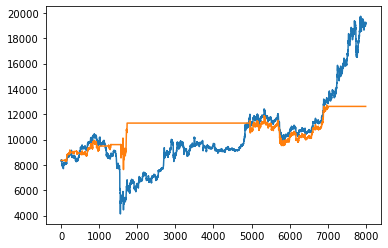

In [565]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


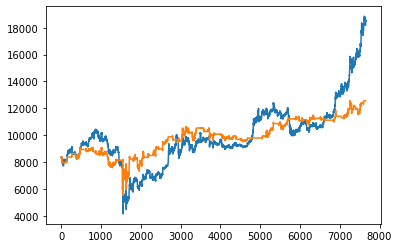

In [995]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

old value calculation

10K


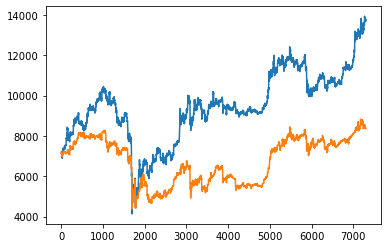

In [217]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

50K


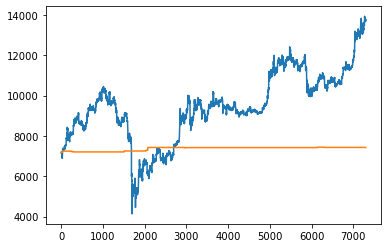

In [225]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

100K


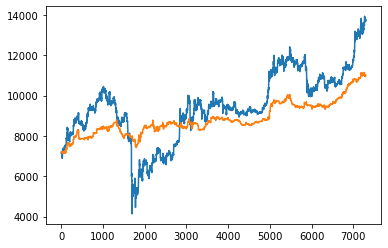

In [248]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

500K


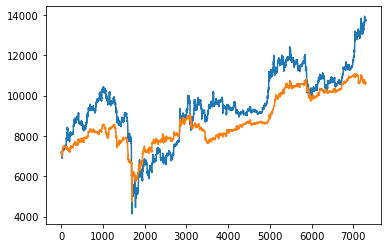

In [253]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

1000K


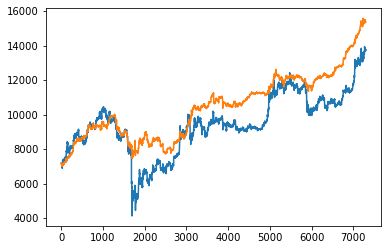

In [264]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

5000K


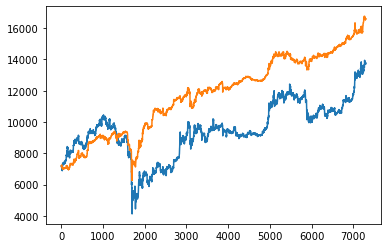

In [270]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(close_list)
plt.plot(np.cumsum(profit_list)+close_list[0])

In [526]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

In [527]:
mean_reward

nan

### Model test 1: multiple binary classification

##### Approximated USDT assets

In [9]:
set1=set([_.replace('BTC','') for _ in klmngr.select(['BTC'], quote=True).sortedkeys()])
set2=set([_.replace('USDT','') for _ in klmngr.select(['USDT'], quote=True).sortedkeys()])

In [10]:
assets_features=klmngr.select([_+'USDT' for _ in list(set1&set2)], quote=False)

In [14]:
np.mean([len(_) for _ in assets_features.listedvalues()])

481.5157894736842

In [13]:
for asset in [_.replace('USDT','') for _ in assets_features.sortedkeys()]:
    new_close=(klmngr[asset+'BTC'].close*klmngr['BTCUSDT'].close).dropna()
    new_asset=assets_features[asset+'USDT'].merge(new_close, how='right', left_index=True, right_index=True)
    new_asset=new_asset.drop('close_x',1).rename(columns={'close_y':'close'})
    assets_features[asset+'USDT']=new_asset

In [15]:
np.mean([len(_) for _ in assets_features.listedvalues()])

481.5157894736842

##### Partitioning

In [16]:
test_period=klmngr['BTCUSDT'].index.values[-round(len(klmngr['BTCUSDT'])*0.3):]

In [17]:
train_period=klmngr['BTCUSDT'].loc[~klmngr['BTCUSDT'].index.isin(test_period)].close.dropna().index

In [18]:
[round(len(klmngr['BTCUSDT'].loc[_,:])/len(klmngr['BTCUSDT']),2) for _ in [train_period,test_period]]

[0.7, 0.3]

##### Constants

In [19]:
max_timeshift=30
window=7*3
half_window=int(round(window/2))

###### Features & targets

In [20]:
all_features_train=np.ndarray((0,794))
all_targets_train=np.ndarray((0))

tmp_fa = np.ndarray((0))
tmp_deriv = np.ndarray((0))
tmp_len = np.ndarray((0))
tmp_k = np.ndarray((0))

In [365]:
# More variables: open, high, close ?
# Different/multiple max_timeshift ?
# Different target window?
# Different target alltoghether?

In [21]:
i=0
for asset in tqdm(assets_features.sortedkeys()):
    
    ### Features
    # Define k
    scaler=StandardScaler()
    k=assets_features[asset].copy()
    matching_index=sorted(set(k.index)&set(train_period))
    if (k.index.min()>=train_period.max()) or (len(matching_index)<max_timeshift+1):
        continue
    k=k.loc[matching_index,:]
    k.close = scaler.fit_transform(k.loc[:,['close']])
    k.loc[:,'sort'] = k.index.values
    k.loc[:,'id'] = 1
    
    # Make rolling duplications to produce windows 
    raw_signals = k.loc[:,['sort', 'id', 'close']] #'open','high','low',
    df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals
                                                                , column_id='id'
                                                                , column_sort='sort'
                                                                , column_kind=None
                                                                , rolling_direction=1
                                                                , max_timeshift=max_timeshift).reset_index(drop=True)
    
    # Drop windows with less than X periods
    size_per_id = df_roll.groupby('id').size().reset_index()
    df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=max_timeshift+1,:].drop(0, axis=1))
    
    # Extract features per window and impute
    extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort', disable_progressbar=True)
    extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)
    
    ### Target
    # Redfine k as it needs to grab future info not present in the training
    k=assets_features[asset].copy()
    k.close = scaler.transform(k.loc[:,['close']])
    # Compute trget per window
    y = future_average = k.close.rolling(window).mean().shift(-half_window)
    deriv_1=(y-y.shift(1))/np.repeat(1,len(y))
    target_mask=((deriv_1>0)&
                 (deriv_1.shift(1)<=0)&
                 (deriv_1.rolling(21).mean().shift(-21)>0.0075)& #21 0.0025
                 (deriv_1.rolling(14).mean().shift(1)<=0.01))
    target = target_mask.rename('target')
    target = pd.DataFrame(target.loc[extracted_features.index])
    target = target.assign(id=target.index.values)
    
    ### NaN
    target = target.dropna()
    extracted_features = extracted_features.loc[target.index,:]
    
    ### Add to receptacles
    all_features_train=np.append(all_features_train,extracted_features.values,0)
    all_targets_train=np.append(all_targets_train,target.target.values)
    
    tmp_k = np.append(tmp_k, k.loc[extracted_features.index,:].close.values)
    tmp_fa = np.append(tmp_fa, y.loc[extracted_features.index].values)
    tmp_deriv = np.append(tmp_deriv, deriv_1.loc[extracted_features.index].values)
    tmp_len = np.append(tmp_len, np.repeat(i,len(extracted_features)))
    i+=1

  0%|                                                   | 0/95 [00:00<?, ?it/s]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

  1%|▍                                          | 1/95 [00:35<55:21, 35.33s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

  7%|███▏                                       | 7/95 [01:15<39:14, 26.75s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:435: UserWarning:

Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__a

  8%|███▌                                       | 8/95 [02:01<47:15, 32.59s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 14%|█████▋                                    | 13/95 [02:50<35:11, 25.75s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 15%|██████▏                                   | 14/95 [03:31<40:41, 30.15s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 16%|██████▋                                   | 15/95 [04:08<43:04, 32.31s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 23%|█████████▋                                | 22/95 [04:29<28:36, 23.51s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 24%|██████████▏                               | 23/95 [05:13<35:38, 29.70s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 25%|██████████▌                               | 24/95 [05:31<30:58, 26.17s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 26%|███████████                               | 25/95 [05:44<25:58, 22.26s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 31%|████████████▊                             | 29/95 [06:19<20:01, 18.21s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 32%|█████████████▎                            | 30/95 [06:58<26:29, 24.46s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 34%|██████████████▏                           | 32/95 [07:44<25:13, 24.03s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 35%|██████████████▌                           | 33/95 [08:29<31:09, 30.16s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 39%|████████████████▎                         | 37/95 [09:12<23:30, 24.32s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 40%|████████████████▊                         | 38/95 [09:48<26:30, 27.90s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 42%|█████████████████▋                        | 40/95 [10:00<19:34, 21.35s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 43%|██████████████████▏                       | 41/95 [10:15<17:29, 19.44s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 44%|██████████████████▌                       | 42/95 [10:48<20:48, 23.56s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 45%|███████████████████                       | 43/95 [11:19<22:27, 25.91s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 46%|███████████████████▍                      | 44/95 [12:12<28:55, 34.02s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 47%|███████████████████▉                      | 45/95 [12:33<24:52, 29.86s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 49%|████████████████████▊                     | 47/95 [12:50<18:46, 23.47s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 51%|█████████████████████▏                    | 48/95 [13:34<23:14, 29.67s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 52%|█████████████████████▋                    | 49/95 [14:12<24:48, 32.35s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 53%|██████████████████████                    | 50/95 [15:02<28:10, 37.57s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 56%|███████████████████████▍                  | 53/95 [15:47<21:32, 30.77s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 57%|███████████████████████▊                  | 54/95 [16:05<18:21, 26.86s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 59%|████████████████████████▊                 | 56/95 [16:46<16:18, 25.08s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 60%|█████████████████████████▏                | 57/95 [17:17<16:52, 26.65s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 61%|█████████████████████████▋                | 58/95 [18:05<20:21, 33.00s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 63%|██████████████████████████▌               | 60/95 [18:22<15:02, 25.78s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 64%|██████████████████████████▉               | 61/95 [19:02<16:54, 29.85s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 66%|███████████████████████████▊              | 63/95 [19:44<14:31, 27.22s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 69%|█████████████████████████████▏            | 66/95 [20:14<10:39, 22.05s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 71%|█████████████████████████████▌            | 67/95 [20:22<08:21, 17.91s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 73%|██████████████████████████████▌           | 69/95 [21:06<08:17, 19.12s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 75%|███████████████████████████████▍          | 71/95 [21:39<07:20, 18.34s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 76%|███████████████████████████████▊          | 72/95 [21:47<05:50, 15.23s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 77%|████████████████████████████████▎         | 73/95 [22:17<07:13, 19.71s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 81%|██████████████████████████████████        | 77/95 [22:37<04:35, 15.29s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 84%|███████████████████████████████████▎      | 80/95 [23:16<03:39, 14.63s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 85%|███████████████████████████████████▊      | 81/95 [23:39<03:57, 16.99s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:435: UserWarning:

Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__a

 86%|████████████████████████████████████▎     | 82/95 [24:05<04:18, 19.85s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 87%|████████████████████████████████████▋     | 83/95 [24:21<03:44, 18.73s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 89%|█████████████████████████████████████▌    | 85/95 [24:48<02:51, 17.14s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 91%|██████████████████████████████████████    | 86/95 [25:25<03:27, 23.08s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 94%|███████████████████████████████████████▎  | 89/95 [26:02<01:58, 19.79s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 95%|███████████████████████████████████████▊  | 90/95 [26:39<02:05, 25.02s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 96%|████████████████████████████████████████▏ | 91/95 [27:17<01:55, 28.82s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 98%|█████████████████████████████████████████ | 93/95 [27:59<00:53, 26.52s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

 99%|█████████████████████████████████████████▌| 94/95 [28:34<00:29, 29.14s/it]C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50_

100%|██████████████████████████████████████████| 95/95 [29:20<00:00, 34.32s/it]


In [23]:
i=0

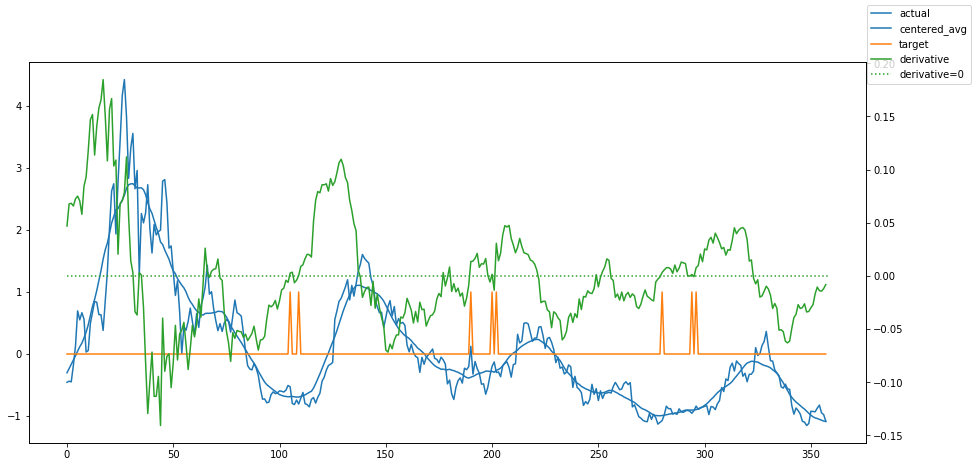

In [25]:
fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
a=ax.plot(tmp_k[tmp_len==np.unique(tmp_len)[i]], color='C0')
b=ax.plot(tmp_fa[tmp_len==np.unique(tmp_len)[i]], color='C0')
c=ax.plot(all_targets_train[tmp_len==np.unique(tmp_len)[i]], color='C1')
d=ax2.plot(tmp_deriv[tmp_len==np.unique(tmp_len)[i]], color='C2')
e=ax2.hlines(0,0,len(tmp_fa[tmp_len==np.unique(tmp_len)[i]]),linestyle=':', color='C2')
i+=1
fig.legend(('actual','centered_avg','target','derivative','derivative=0'))

In [26]:
all_selected_features_train = tsf.select_features(
    pd.DataFrame(all_features_train),
    all_targets_train.astype(bool))

In [28]:
all_features_train.shape

(15763, 794)

In [29]:
all_selected_features_train.shape

(15763, 100)

In [30]:
selected_columns=all_selected_features_train.columns

In [31]:
all_selected_features_train=all_selected_features_train.values

##### Fit

In [32]:
clf = VotingClassifier([('clf1', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=5)),
                        ('clf2', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=5)),
                        ('clf3', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=5)),
                        ('clf5', CalibratedClassifierCV(KNeighborsClassifier(), cv=5)),
                        ('clf7', CalibratedClassifierCV(GaussianNB(), cv=5)),
                        ('clf8', CalibratedClassifierCV(LogisticRegression(solver='lbfgs', max_iter=250), cv=5)),
                       ], voting='soft')

In [33]:
fit=clf.fit(X=all_selected_features_train, y=all_targets_train.astype(bool))

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\GUIX\Anaconda3\

##### Test

In [34]:
asset='BTCUSDT'

### Features
# Define k
scaler=StandardScaler()
k=klmngr[asset].copy()
k=k.loc[:,:]
scaler.fit(k.loc[train_period,['close']])
k.close = scaler.transform(k.loc[:,['close']])
k.loc[:,'sort'] = k.index.values
k.loc[:,'id'] = 1

# Make rolling duplications to produce windows 
raw_signals = k.loc[:,['sort', 'id', 'close']] #'open','high','low',
df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals
                                                            , column_id='id'
                                                            , column_sort='sort'
                                                            , column_kind=None
                                                            , rolling_direction=1
                                                            , max_timeshift=max_timeshift).reset_index(drop=True)

# Drop windows with less than X periods
size_per_id = df_roll.groupby('id').size().reset_index()
df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=max_timeshift+1,:].drop(0, axis=1))

# Extract features per window and impute
extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort', disable_progressbar=True)
extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)
extracted_features = extracted_features.loc[test_period,:]

### Target
# Redfine k as it needs to grab future info not present in the training
k=klmngr[asset].copy()
k.close = scaler.transform(k.loc[:,['close']])
# Compute trget per window
y = future_average = k.close.rolling(window).mean().shift(-half_window)
deriv_1=(y-y.shift(1))/np.repeat(1,len(y))
target_mask=((deriv_1>0)&
             (deriv_1.shift(1)<=0)&
             (deriv_1.rolling(21).mean().shift(-21)>0.0075)& #21 0.0025
             (deriv_1.rolling(14).mean().shift(1)<=0.01))
target = target_mask.rename('target')
target = pd.DataFrame(target.loc[extracted_features.index])
target = target.assign(id=target.index.values)

### NaN
target = target.dropna()
extracted_features = extracted_features.loc[target.index,:]

### Selected columns
extracted_features = pd.DataFrame(extracted_features.values).loc[:,selected_columns]

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'close__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stde

In [35]:
probas_pred = fit.predict_proba(X=extracted_features)[:,1]
precision, recall, _ = precision_recall_curve(y_true=target.target.values.astype(int)
                                              , probas_pred=probas_pred)

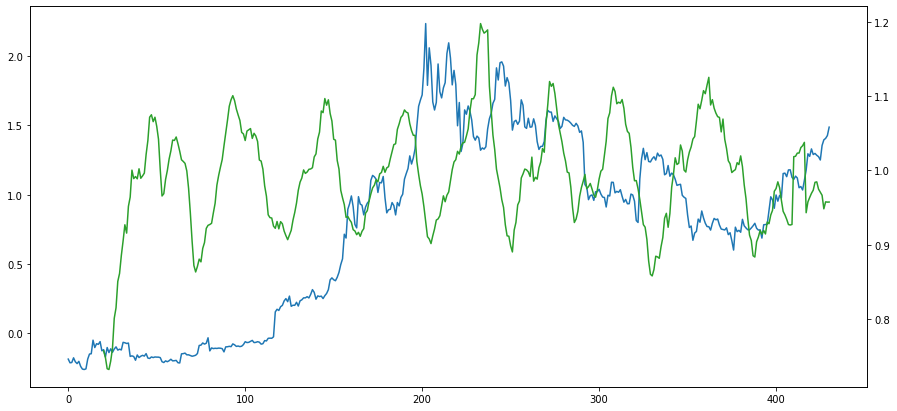

In [36]:
fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
ax.plot(k.loc[test_period,:].close.values, color='C0')
#ax2.plot(pd.Series(probas_pred), color='C1')
#ax2.plot(pd.Series(probas_pred).rolling(21).mean(), color='C2')
ax2.plot(pd.Series(probas_pred).rolling(7).mean()/pd.Series(probas_pred).rolling(21).mean(), color='C2')

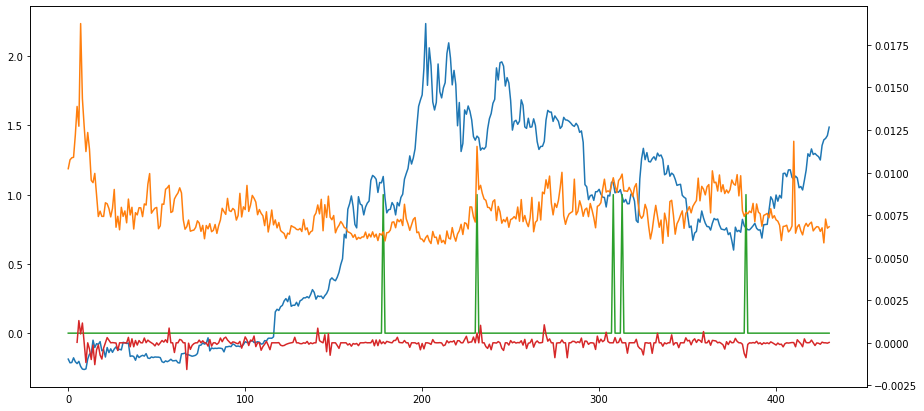

In [37]:
fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
ax.plot(k.loc[test_period,:].close.values, color='C0')
ax.plot(target.target.values, color='C2')
ax2.plot(probas_pred, color='C1')
ax2.plot(pd.Series(probas_pred).rolling(5).median().diff(1), color='C3')

In [38]:
probas_pred2=(pd.Series(probas_pred).rolling(7).mean()/pd.Series(probas_pred).rolling(21).mean()).fillna(0).values

In [39]:
k=klmngr[asset]

In [40]:
# BUY & SELL based on target movements
positions=dict()
funds_usdt_equivalent_dic = dict()

thresholds = np.unique(np.sort(np.unique(probas_pred2)).round(2))
for threshold in thresholds:
    positions[threshold]=[]
    start_funds = 1000
    funds = start_funds
    funds_usdt_equivalent = [funds]
    position = 'USDT'
    for i, day in enumerate(target.index):
        positions[threshold].append(position)
        if probas_pred2[i]>=threshold:
            if position == 'USDT':
                funds = funds/k.loc[day, 'close']
                position = 'BTC'
        else:
            if position != 'USDT':
                funds = funds*k.loc[day, 'close']
                position = 'USDT'
        usdt_equivalent = funds if position == 'USDT' else funds*k.loc[day, 'close']
        #print(i, day, usdt_equivalent)
        funds_usdt_equivalent.append(usdt_equivalent)
    funds_usdt_equivalent_dic[threshold] = funds_usdt_equivalent

In [41]:
print("hold posit. :"
      , -1*round(k.loc[test_period, 'close'][0]/min(k.loc[test_period, 'close']), 2)
      , round(max(k.loc[test_period, 'close'])/k.loc[test_period, 'close'][0], 2)
      , round(k.loc[test_period, 'close'][-1]/k.loc[test_period, 'close'][0], 2)
     )

for threshold in thresholds:
    print("proba >= {}".format(threshold), ":"
          , -1*round(funds_usdt_equivalent_dic[threshold][0]/min(funds_usdt_equivalent_dic[threshold]), 2)
          ,    round(max(funds_usdt_equivalent_dic[threshold])/funds_usdt_equivalent_dic[threshold][0], 2)
          ,    round(funds_usdt_equivalent_dic[threshold][-1]/funds_usdt_equivalent_dic[threshold][0],  2)
         )

hold posit. : -1.09 3.73 2.89
proba >= 0.0 : -1.09 3.73 2.89
proba >= 0.73 : -1.11 3.47 2.68
proba >= 0.74 : -1.1 3.5 2.71
proba >= 0.75 : -1.15 3.34 2.59
proba >= 0.76 : -1.09 3.54 2.74
proba >= 0.8 : -1.12 3.45 2.67
proba >= 0.82 : -1.11 3.48 2.69
proba >= 0.85 : -1.11 3.48 2.69
proba >= 0.86 : -1.12 3.45 2.66
proba >= 0.87 : -1.11 3.43 2.64
proba >= 0.88 : -1.12 3.16 2.43
proba >= 0.89 : -1.18 2.98 2.28
proba >= 0.9 : -1.17 3.0 2.47
proba >= 0.91 : -1.18 3.17 2.93
proba >= 0.92 : -1.18 3.0 2.85
proba >= 0.93 : -1.17 2.56 2.43
proba >= 0.94 : -1.17 2.57 2.29
proba >= 0.95 : -1.17 2.48 2.1
proba >= 0.96 : -1.06 2.17 1.63
proba >= 0.97 : -1.07 1.68 1.14
proba >= 0.98 : -1.16 1.59 0.98
proba >= 0.99 : -1.01 1.75 1.4
proba >= 1.0 : -1.08 1.94 1.6
proba >= 1.01 : -1.05 1.9 1.74
proba >= 1.02 : -1.06 2.05 1.87
proba >= 1.03 : -1.01 1.91 1.84
proba >= 1.04 : -1.01 1.65 1.55
proba >= 1.05 : -1.0 1.37 1.28
proba >= 1.06 : -1.0 1.33 1.24
proba >= 1.07 : -1.01 1.31 1.19
proba >= 1.08 : -1.0 1.1

In [42]:
scale = k.loc[test_period, 'close'].values[0]/start_funds

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



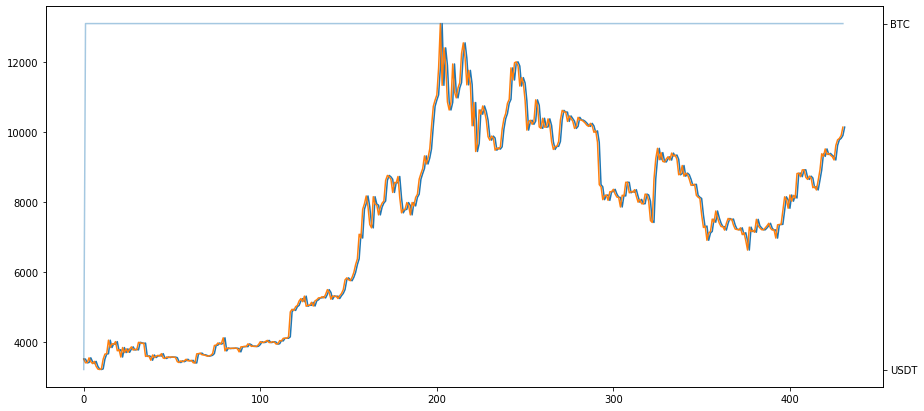

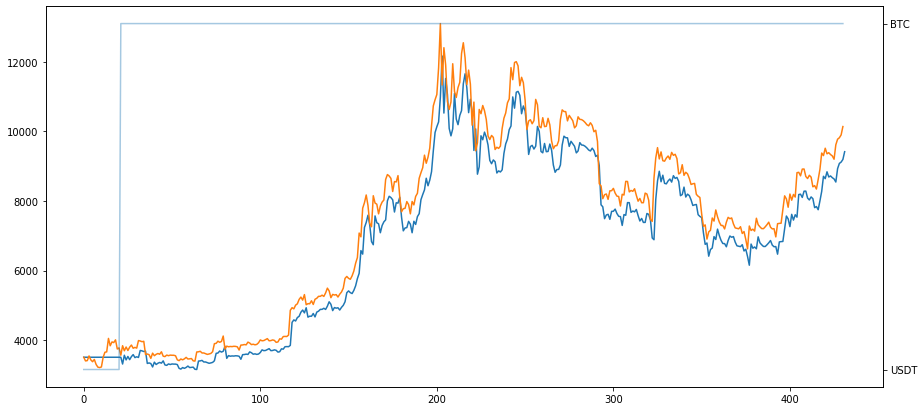

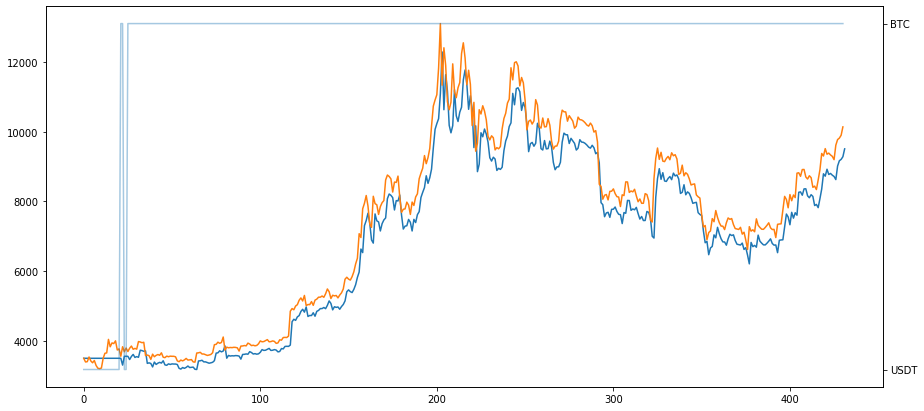

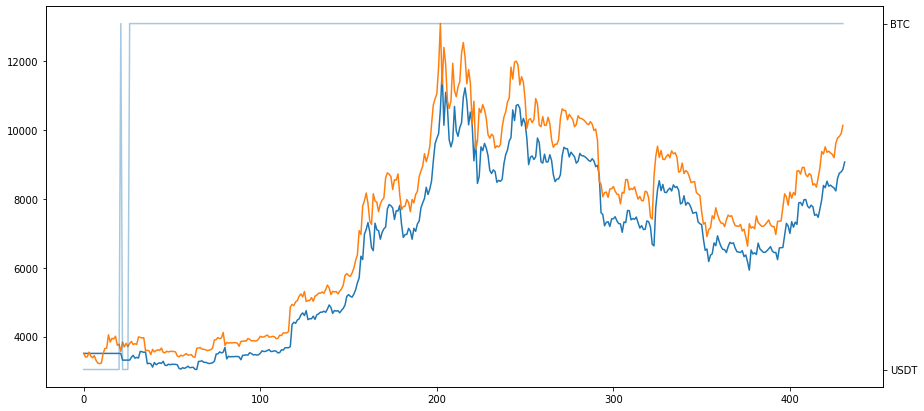

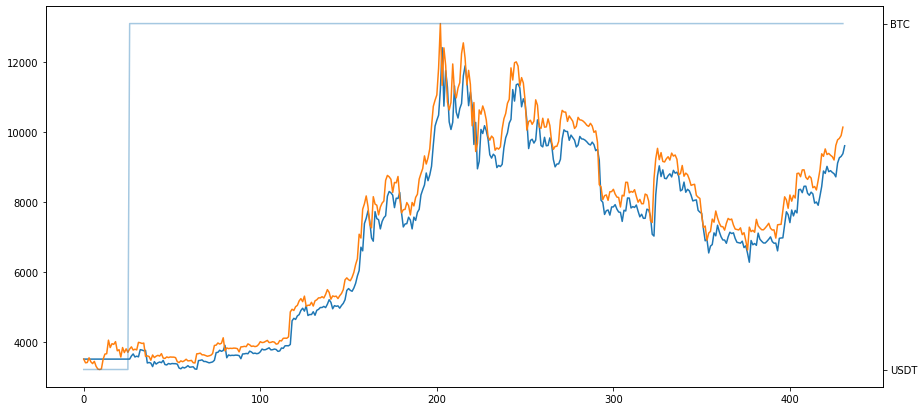

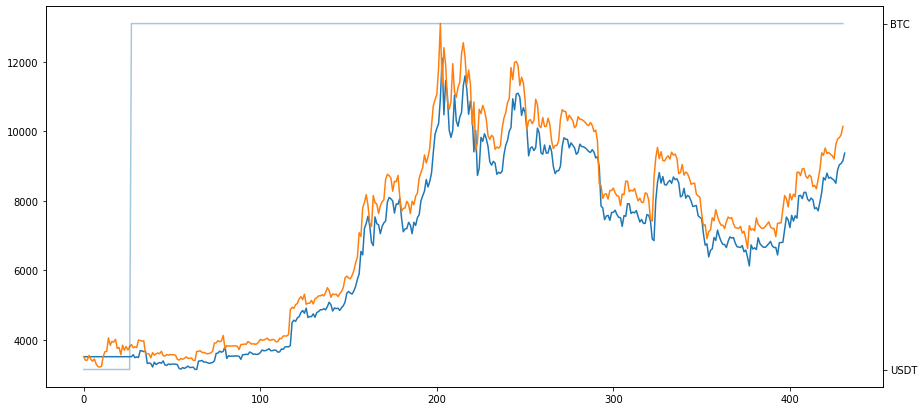

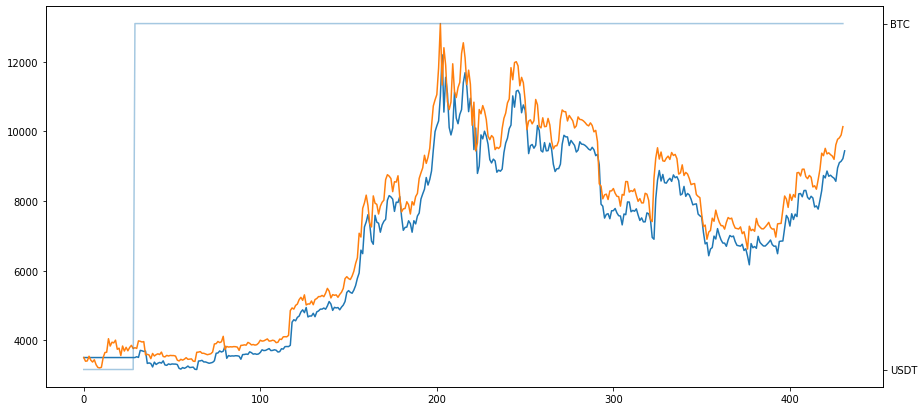

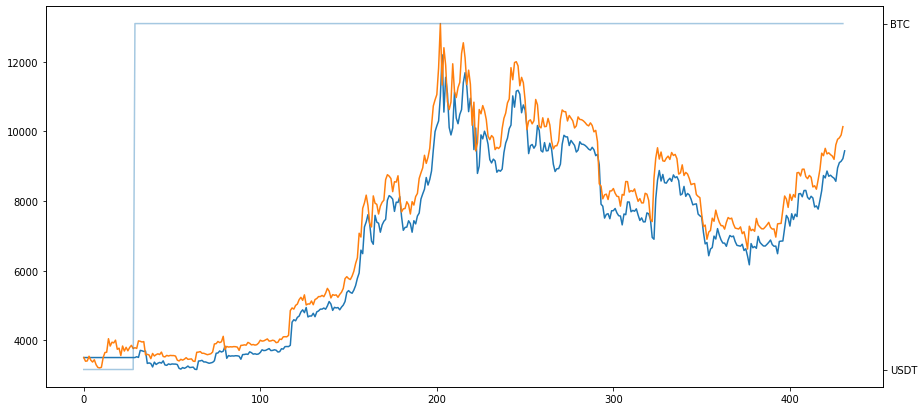

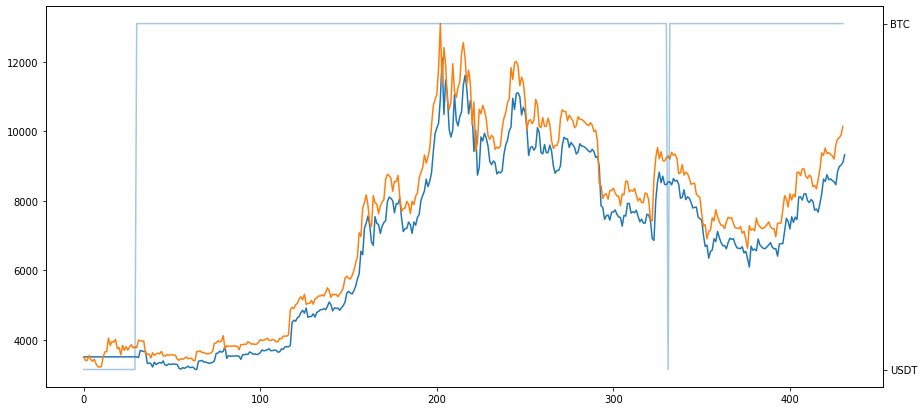

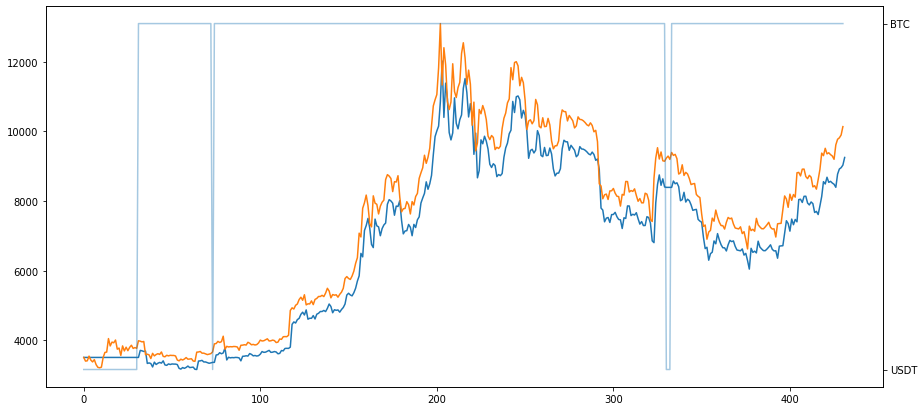

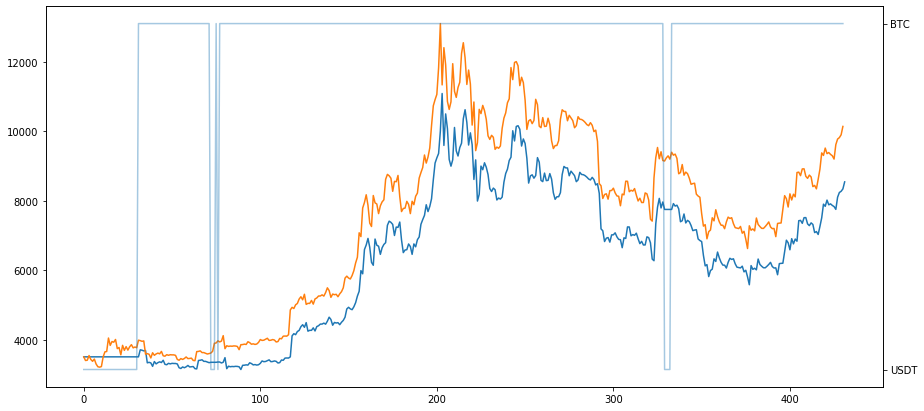

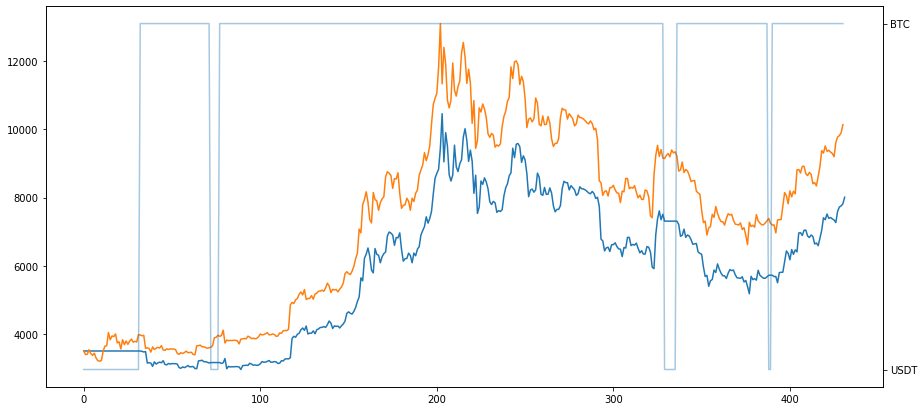

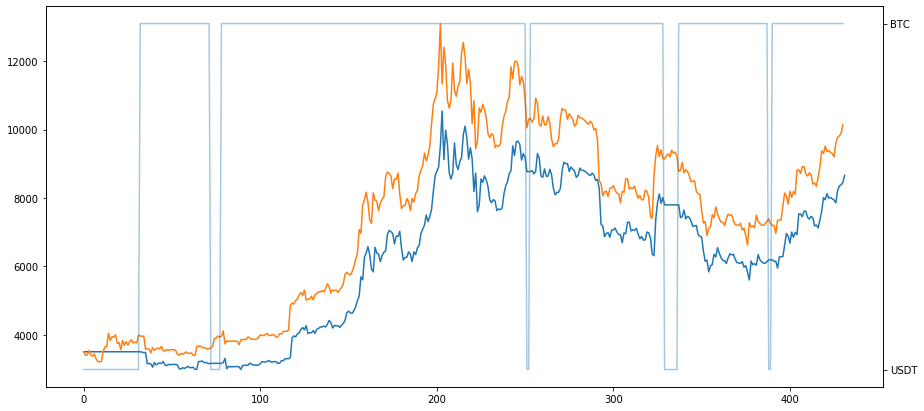

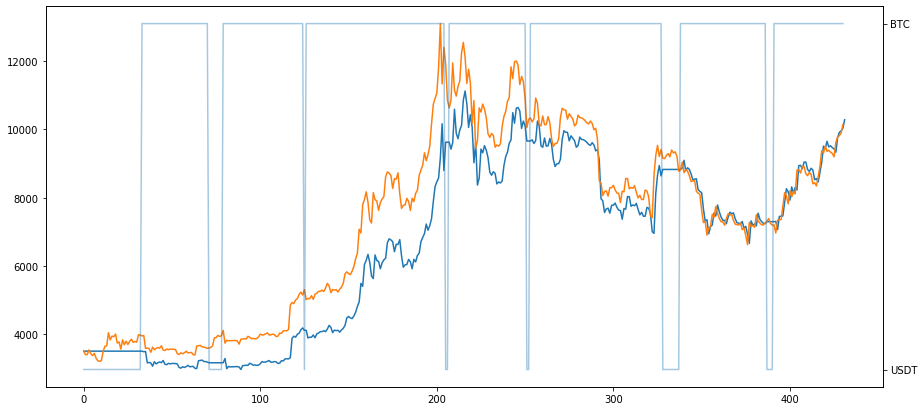

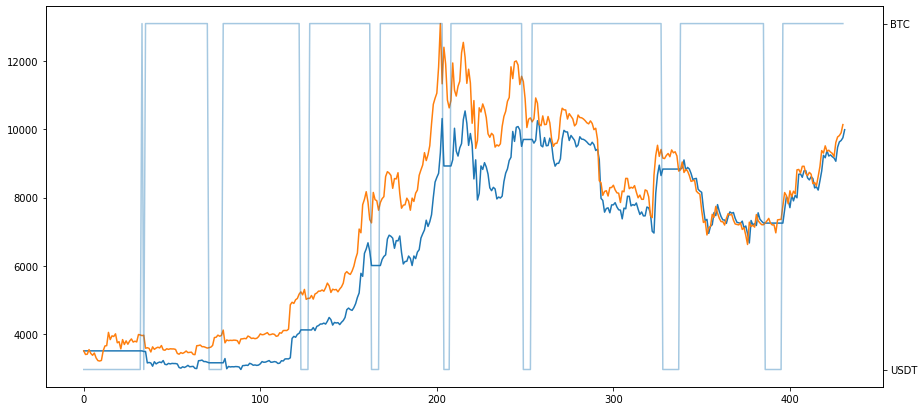

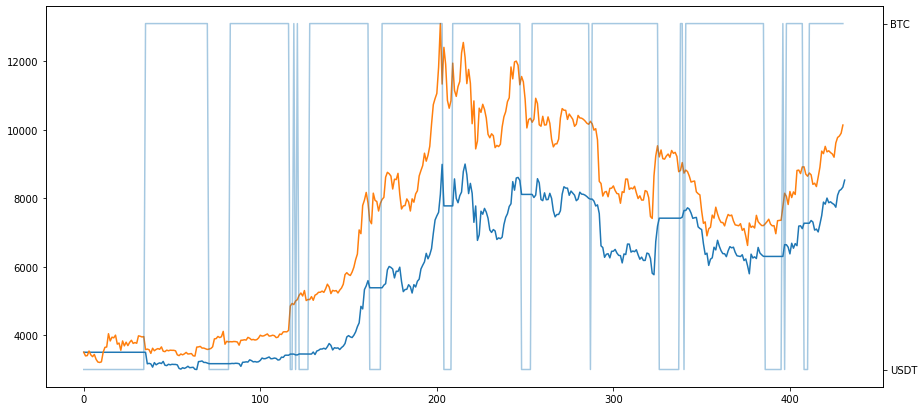

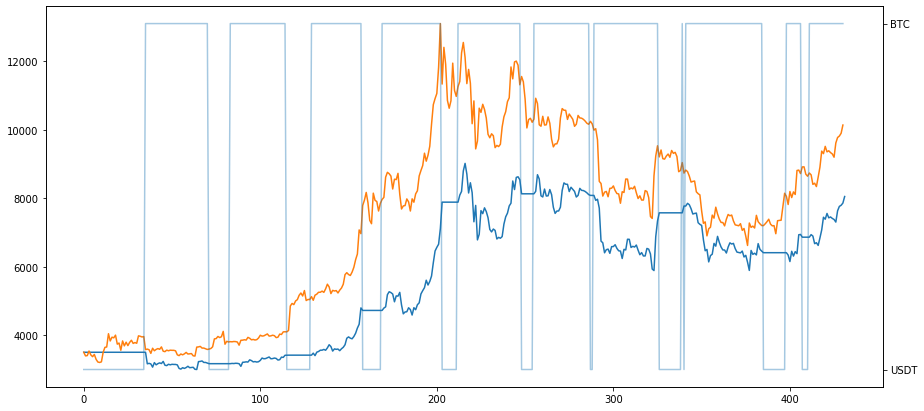

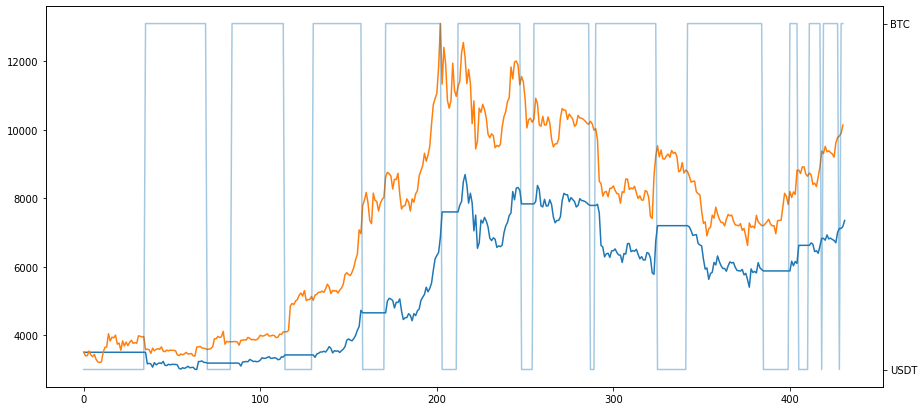

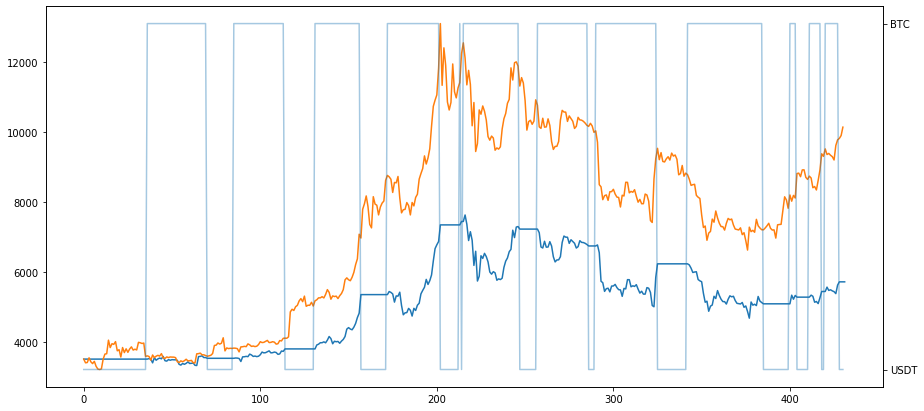

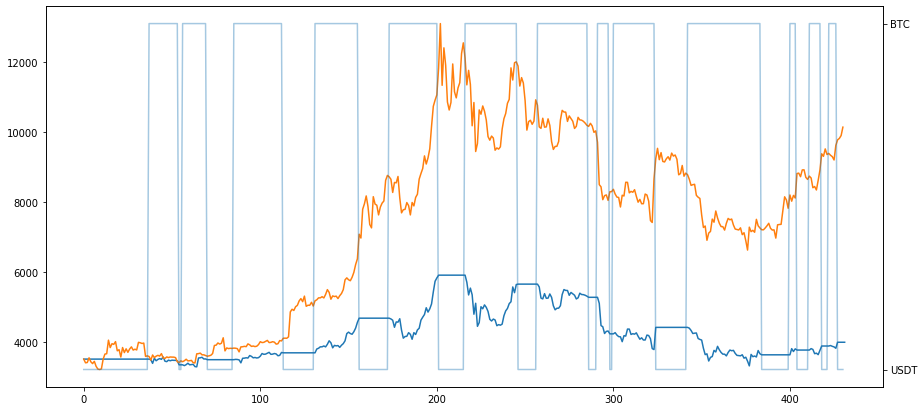

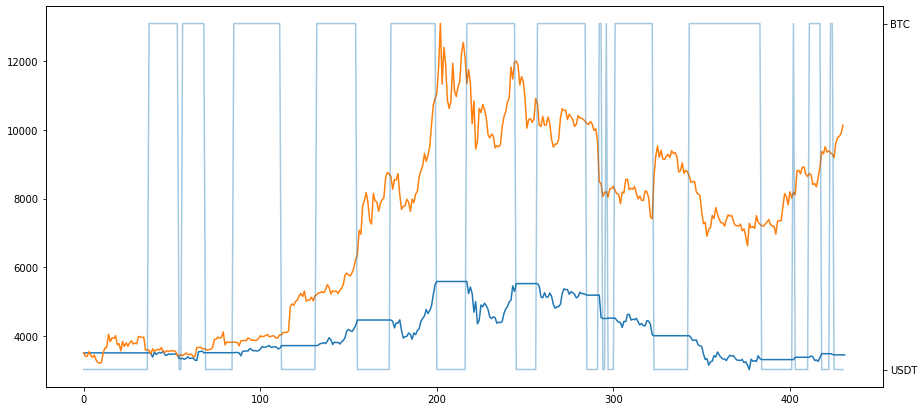

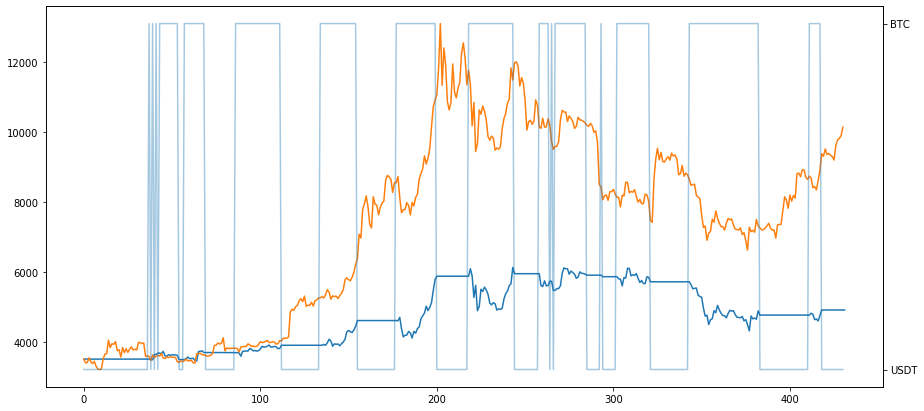

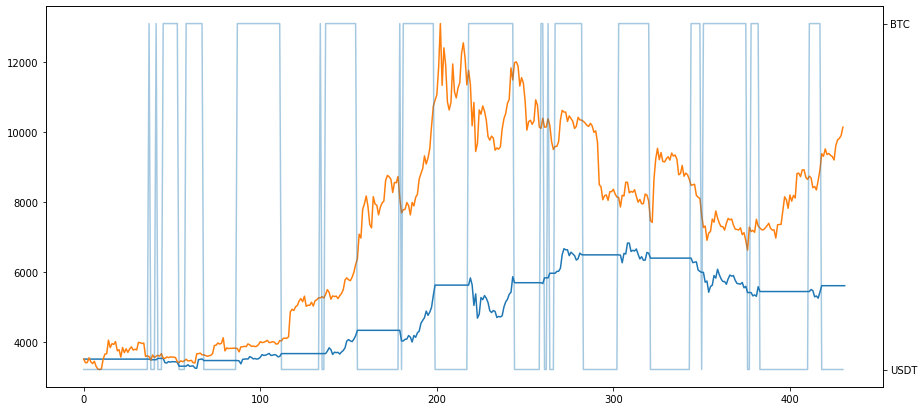

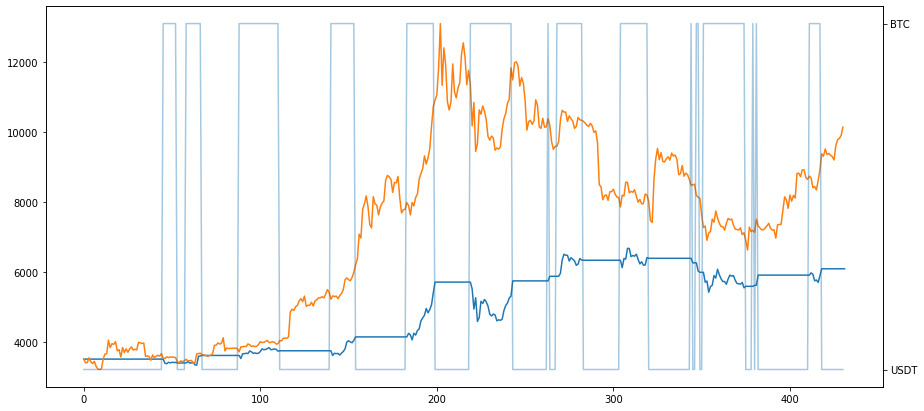

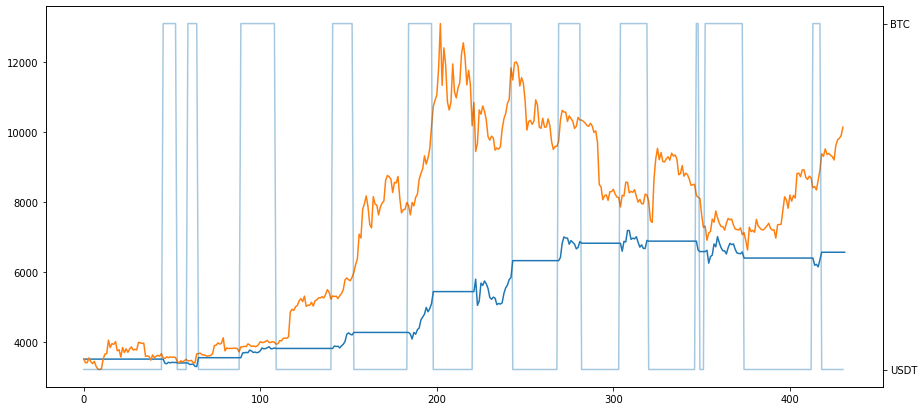

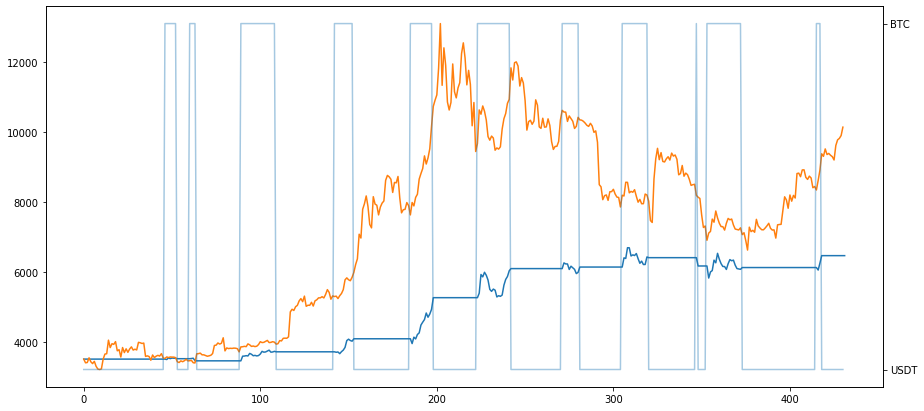

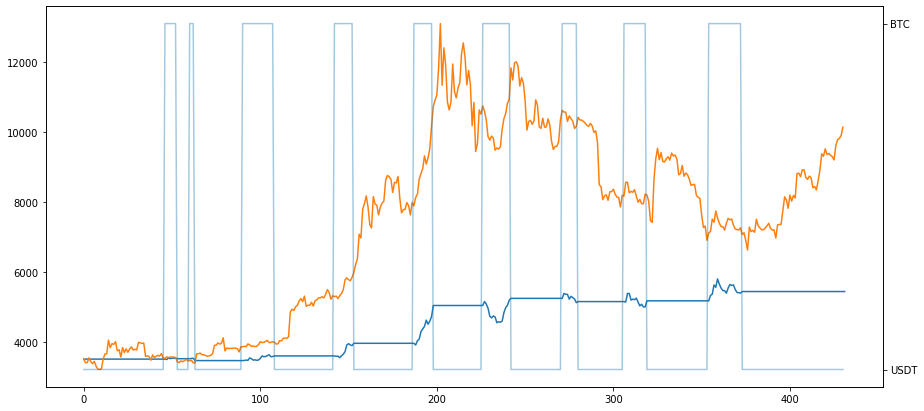

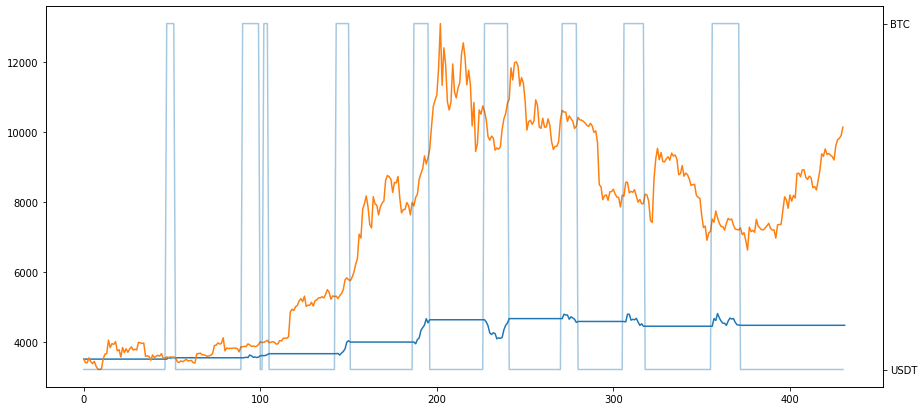

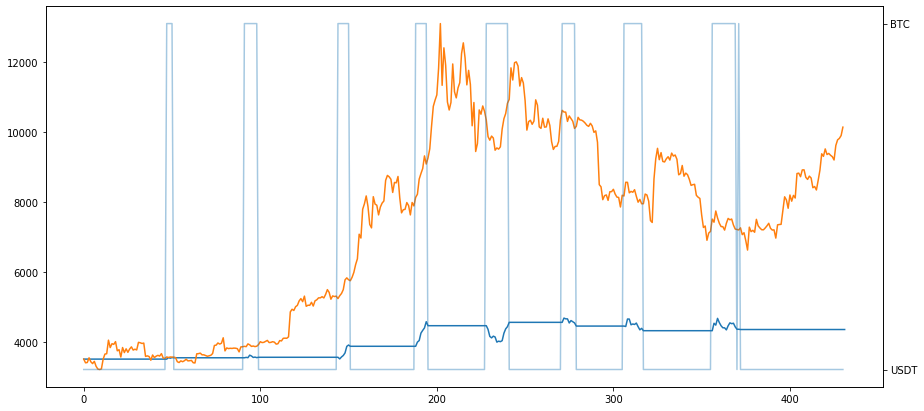

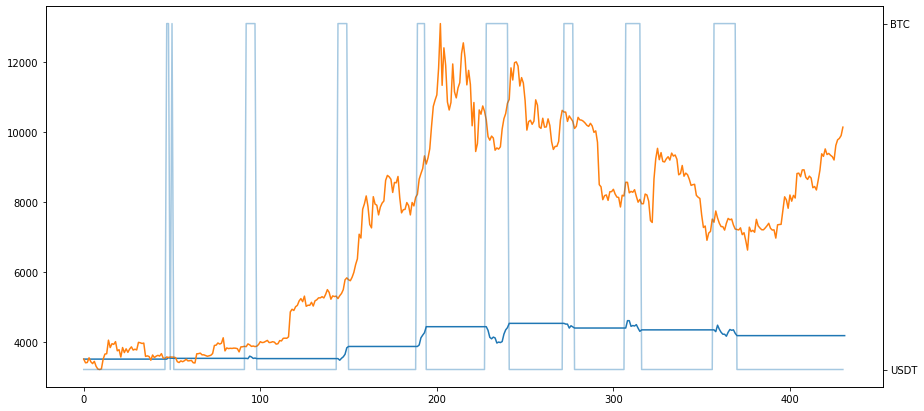

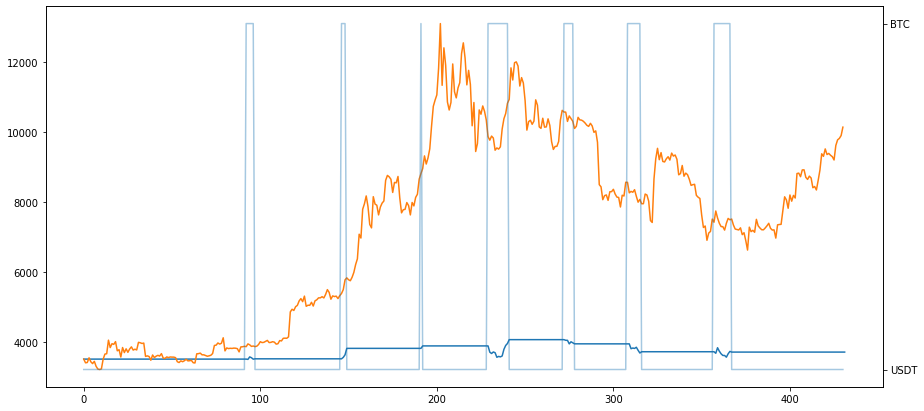

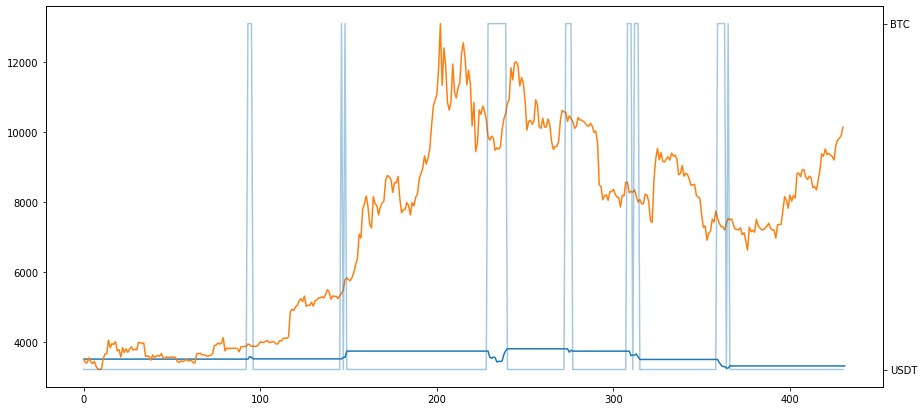

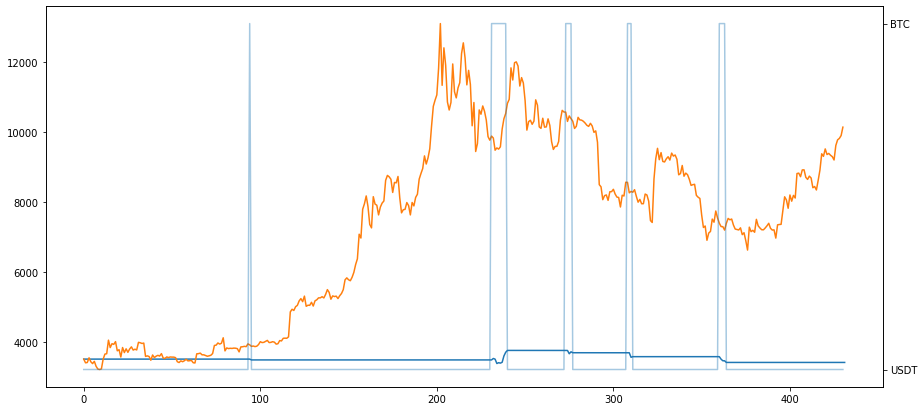

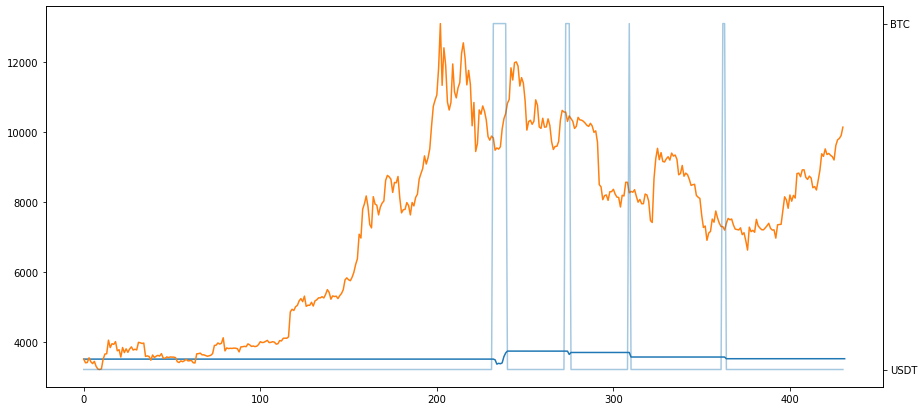

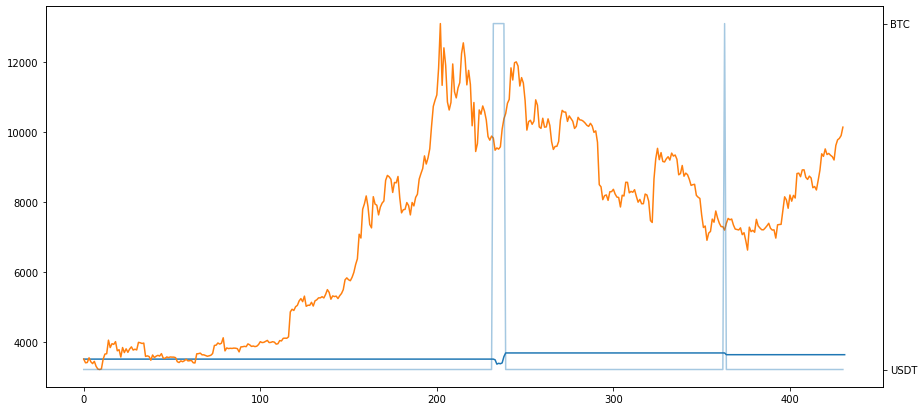

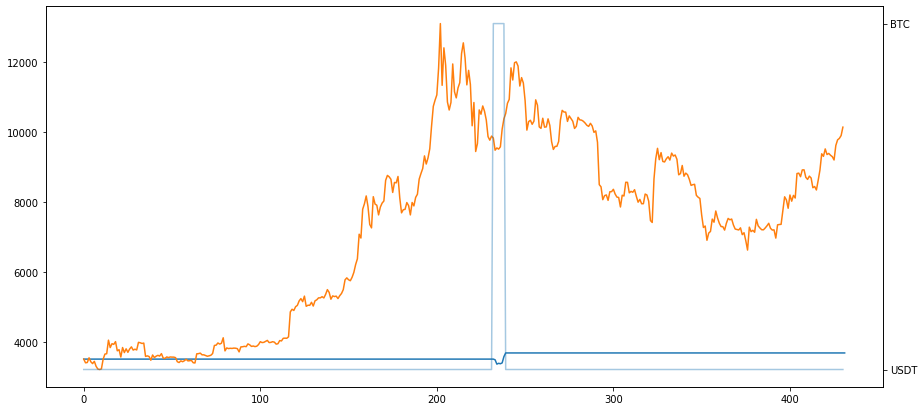

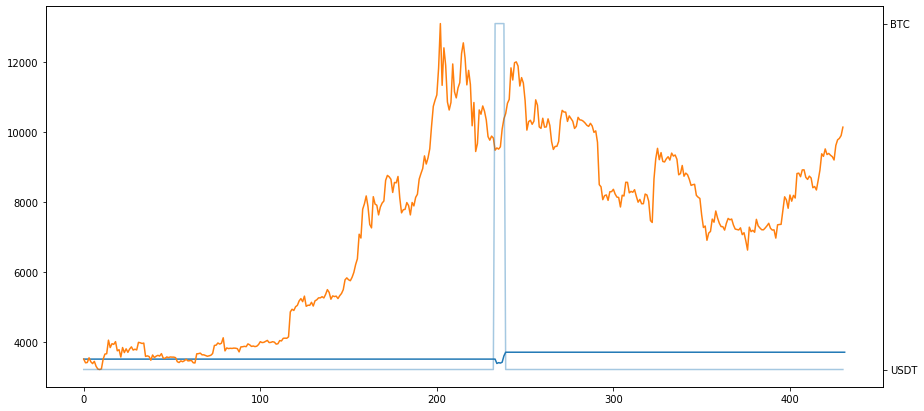

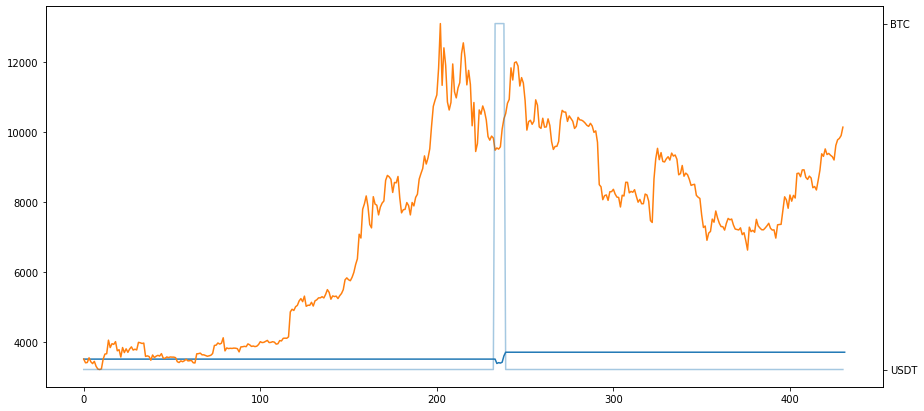

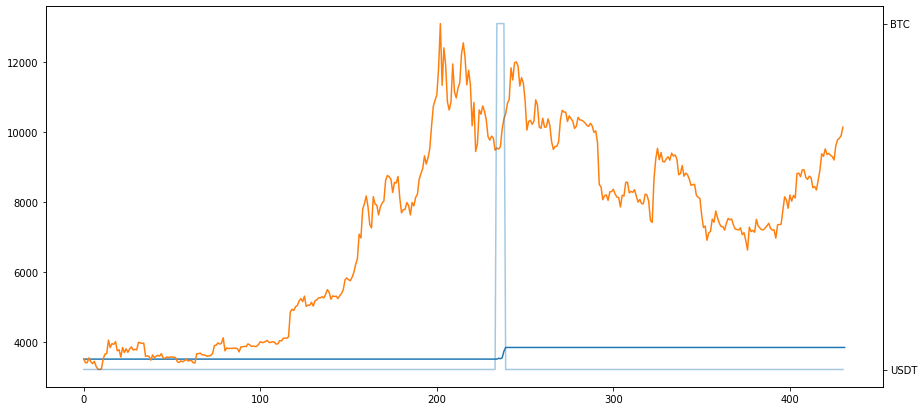

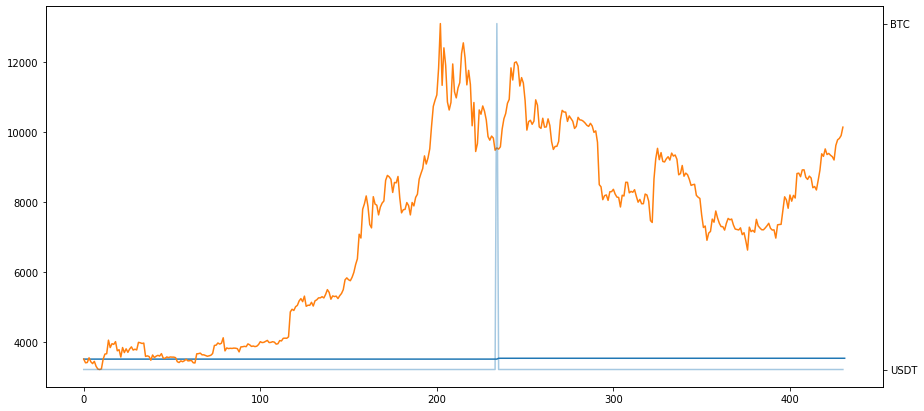

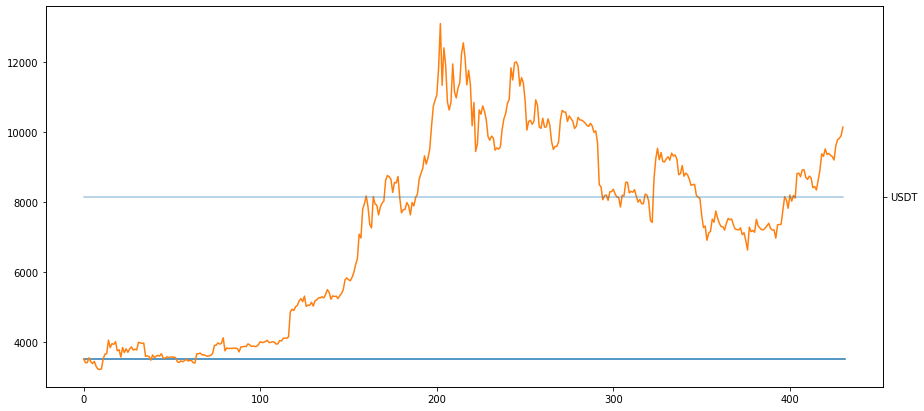

In [43]:
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    ax.plot(np.array(k.loc[test_period, 'close']))
    ax2=ax.twinx()
    ax2.plot(range(len(test_period)),positions[threshold], alpha=.4)

### Model test 2: binary classification

##### Kline and tsfresh columns

In [11]:
asset_features='BTCUSDT'

In [12]:
mngr[asset_features];

In [13]:
k = mngr[asset_features].copy()
k.loc[:,'sort'] = k.index.values
k.loc[:,'id'] = 1

##### Make rolling duplications to produce windows 

In [14]:
raw_signals = k.loc[:,['sort', 'id', 'open','high','low','close']]

In [15]:
df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals
                                                            , column_id='id'
                                                            , column_sort='sort'
                                                            , column_kind=None
                                                            , rolling_direction=1
                                                            , max_timeshift=30).reset_index(drop=True)

##### Drop windows with less than X periods

In [16]:
size_per_id = df_roll.groupby('id').size().reset_index()
df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=31,:].drop(0, axis=1))

##### Extract features per window and impute

In [17]:
extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort')

Feature Extraction: 100%|██████████████████████| 20/20 [08:11<00:00, 14.56s/it]


In [18]:
extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...
 'open__fft_coefficient__coeff_99__attr_"angle"'
 'open__fft_coefficient__coeff_99__attr_"imag"'
 'open__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


##### Compute target per window

Pits

In [19]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
window = 7*3
half_window = int(round(window/2))
fig.add_trace(go.Scatter(x=k.index,y=k.close))
y = future_average = k.close.rolling(window).mean().shift(-half_window)
fig.add_trace(go.Scatter(x=future_average.index, y=future_average))

deriv_1=(y-y.shift(1))/np.repeat(1,len(y))

target_mask=((deriv_1>0)&
             (deriv_1.shift(1)<0)&
             (deriv_1.rolling(21).mean().shift(-21)>10)& # 0.0025
             (deriv_1.rolling(7).mean()<=0))
fig.add_trace(go.Scatter(x=target_mask.index, y=target_mask.astype(int), mode='none', fill='tozeroy',
                         fillcolor='black', name='target'), secondary_y=True)
target=target_mask.rename('target')

In [20]:
target = pd.DataFrame(target.loc[extracted_features.index])
target = target.assign(id=target.index.values)

##### Select features based on target

In [21]:
selected_features = tsf.select_features(extracted_features.loc[target.id,:], target.target.values)
#selected_features = extracted_features.loc[target.id,:]

In [22]:
train_period = selected_features.index.values[:round(len(selected_features)*0.7)]
test_period = selected_features.loc[~selected_features.index.isin(train_period)].dropna().index

In [127]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [190]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, )

In [ ]:
clf = VotingClassifier([('clf1', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=3)),
                        ('clf2', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=3)),
                        ('clf3', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=3)),
                        ('clf4', CalibratedClassifierCV(ExtraTreesClassifier(n_estimators=100), cv=3)),
                        ('clf5', CalibratedClassifierCV(KNeighborsClassifier(), cv=3)),
                        ('clf7', CalibratedClassifierCV(GaussianNB(), cv=3)),
                        ('clf8', CalibratedClassifierCV(LogisticRegression(solver='lbfgs', max_iter=250), cv=3)),
                       ], voting='soft')

In [191]:
fit=clf.fit(X=selected_features.loc[train_period].values, y=target.loc[train_period, 'target'].values.astype(int));

In [192]:
roc_auc_score(y_true=target.loc[train_period, 'target'].values.astype(int)
              , y_score=fit.predict(X=selected_features.loc[train_period].values))

1.0

In [193]:
roc_auc_score(y_true=target.loc[test_period, 'target'].values.astype(int)
              , y_score=fit.predict(X=selected_features.loc[test_period].values))

0.5

In [194]:
probas_pred = fit.predict_proba(X=selected_features.loc[test_period].values.astype(int))[:,1]
precision, recall, _ = precision_recall_curve(y_true=target.loc[test_period, 'target'].values.astype(int)
                                              , probas_pred=probas_pred)

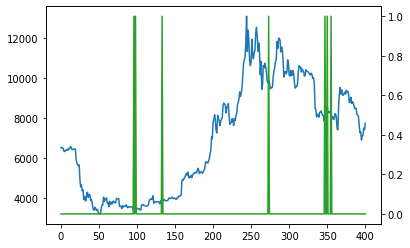

In [195]:
fig,ax=plt.subplots()
ax.plot(k.close.loc[test_period].values, color='C0')
ax2=ax.twinx()
#ax2.plot(probas_pred, color='C1')
ax2.plot(target.target.loc[test_period].astype(int).values, color='C2')

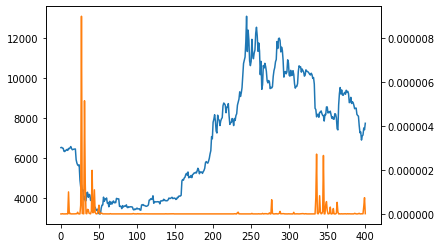

In [196]:
fig,ax=plt.subplots()
ax.plot(k.close.loc[test_period].values, color='C0')
ax2=ax.twinx()
ax2.plot(probas_pred, color='C1')
#ax2.plot(target.target.loc[test_period].astype(int).values, color='C2')

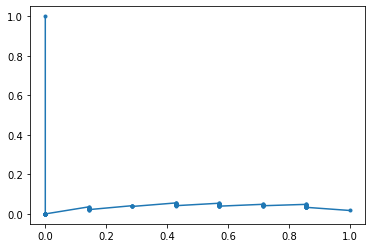

In [31]:
plt.plot(recall, precision, marker='.')

In [186]:
# BUY & SELL following target window

funds_usdt_equivalent_dic = dict()

thresholds = np.sort(np.unique(probas_pred))
#thresholds = thresholds[thresholds>0.5]
thresholds = np.unique(thresholds.round(1))
for threshold in thresholds:
    hold_period = 15
    start_funds = 1000
    funds = start_funds
    funds_usdt_equivalent = [funds]
    position = 'USDT'
    for i, day in enumerate(test_period):
        hold_period = max(0, hold_period-1)
        if probas_pred[i]>=threshold:
            hold_period = 21
        if hold_period > 0:
            if position == 'USDT':
                funds = funds/k.loc[day, 'close']
                position = 'BTC'
        elif position != 'USDT':
            funds = funds*k.loc[day, 'close']
            position = 'USDT'
        usdt_equivalent = funds if position == 'USDT' else funds*k.loc[day, 'close']
        #print(i, day, usdt_equivalent)
        funds_usdt_equivalent.append(usdt_equivalent)
    funds_usdt_equivalent_dic[threshold] = funds_usdt_equivalent

In [187]:
print("hold posit. :"
      , -1*round(k.loc[test_period, 'close'][0]/min(k.loc[test_period, 'close']), 2)
      , round(max(k.loc[test_period, 'close'])/k.loc[test_period, 'close'][0], 2)
      , round(k.loc[test_period, 'close'][-1]/k.loc[test_period, 'close'][0], 2)
     )

for threshold in thresholds:
    print("proba >= {}".format(threshold), ":"
          , -1*round(funds_usdt_equivalent_dic[threshold][0]/min(funds_usdt_equivalent_dic[threshold]), 2)
          ,    round(max(funds_usdt_equivalent_dic[threshold])/funds_usdt_equivalent_dic[threshold][0], 2)
          ,    round(funds_usdt_equivalent_dic[threshold][-1]/funds_usdt_equivalent_dic[threshold][0],  2)
         )

hold posit. : -1.95 2.09 1.41
proba >= 0.0 : -1.95 2.09 1.41
proba >= 0.1 : -1.95 2.09 1.41
proba >= 0.2 : -1.95 2.09 1.41
proba >= 0.3 : -1.95 2.09 1.41
proba >= 0.4 : -1.95 2.09 1.64
proba >= 0.5 : -1.95 2.09 1.76
proba >= 0.6 : -1.95 2.22 2.05
proba >= 0.7 : -1.96 1.98 1.81
proba >= 0.8 : -1.94 1.92 1.75
proba >= 0.9 : -1.21 2.24 1.67
proba >= 1.0 : -1.0 1.08 1.04


In [188]:
scale = k.loc[test_period, 'close'].values[0]/start_funds

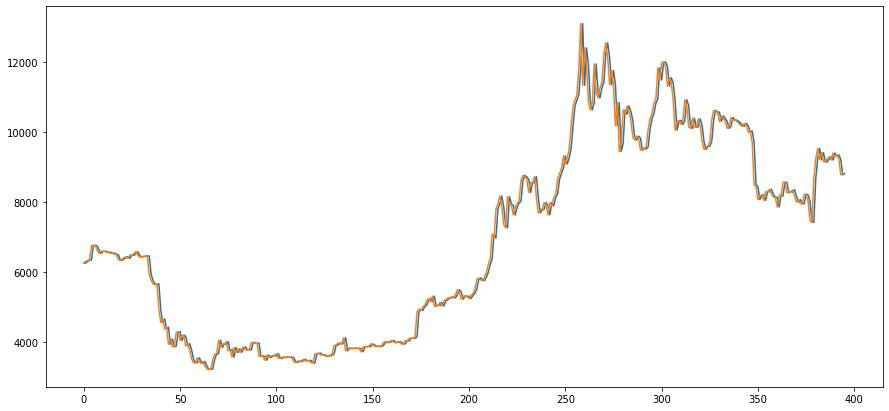

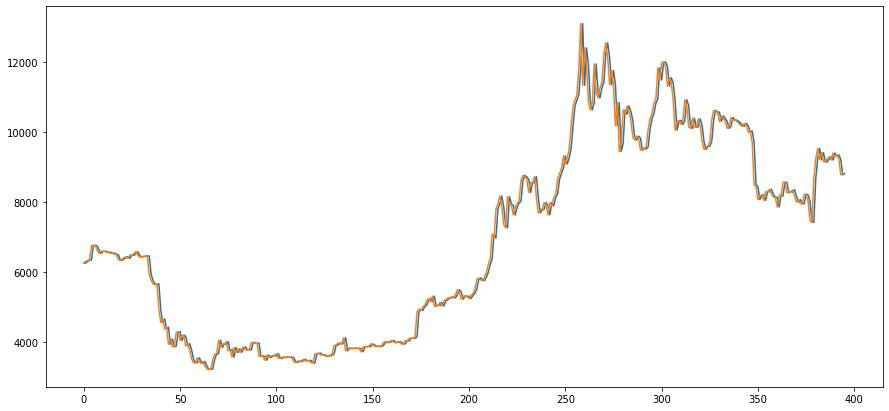

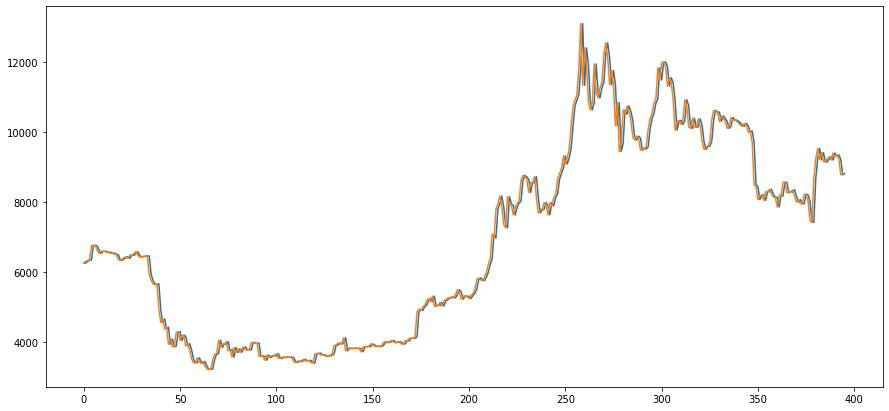

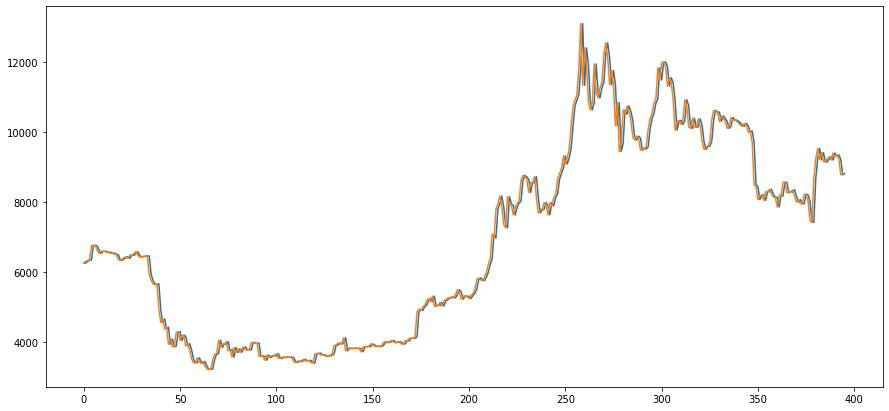

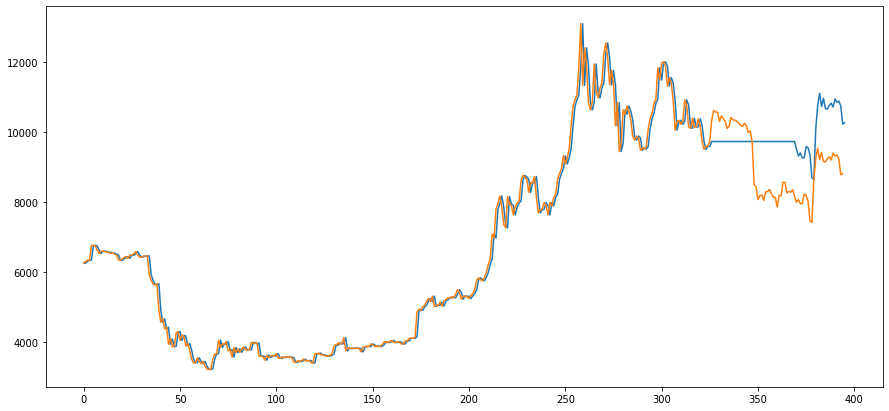

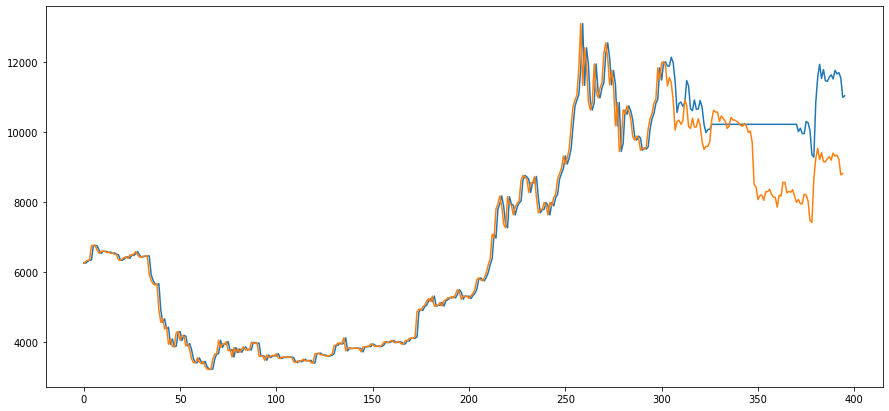

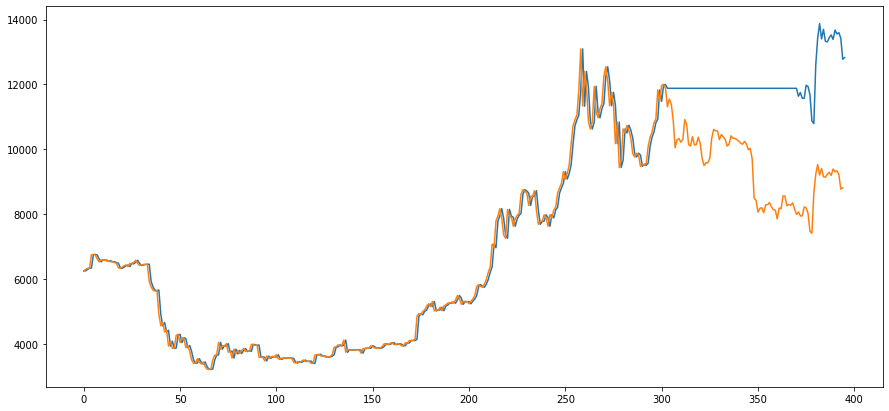

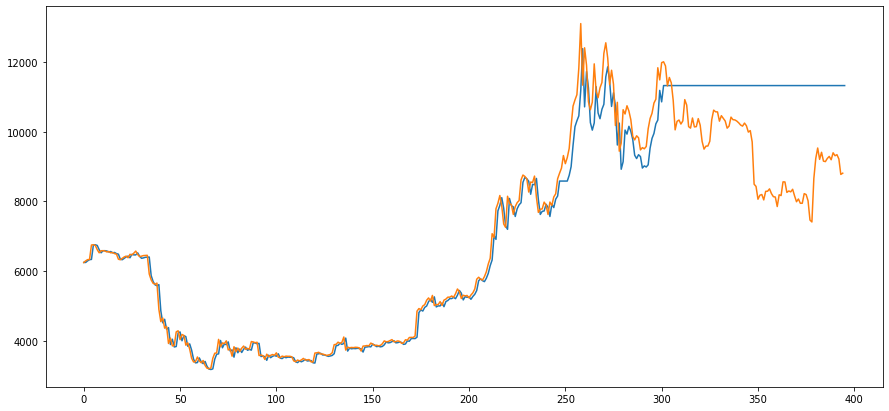

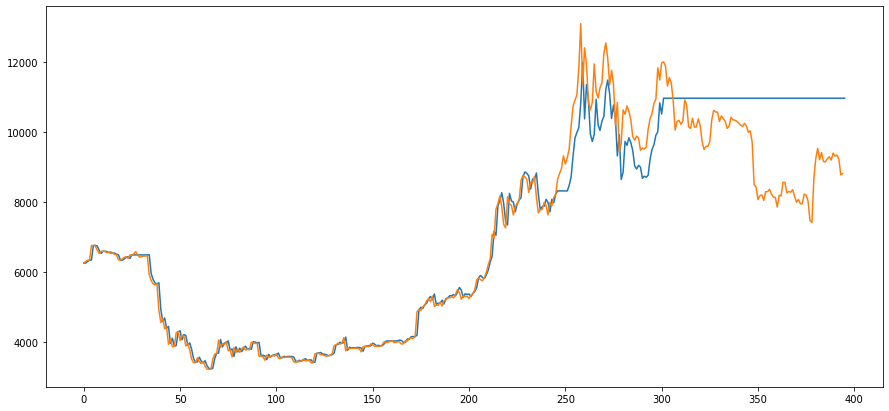

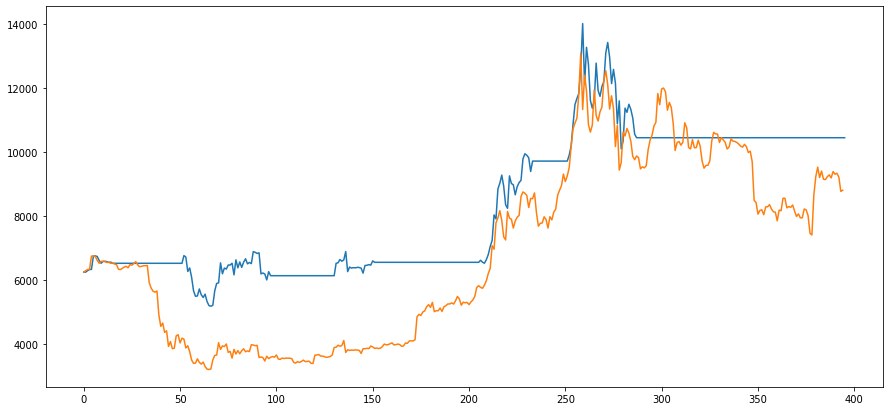

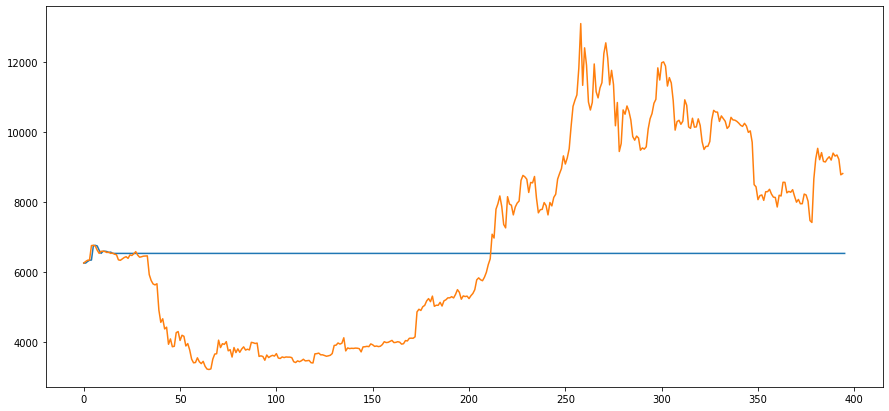

In [189]:
# Voting
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    plt.plot(np.array(k.loc[test_period, 'close']))

---

In [44]:
# Ada
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    plt.plot(np.array(k.loc[test_period, 'close']))